In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from bci.core import expstruct as et

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf

from h5tools import h5tools as h5
from streamtools import streams as st
from streamtools import spectral as sp
from streamtools import temporal as tp

import spike_detect_aux as aux

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

print 'All modules loaded'

Computer: passaro
All modules loaded


In [2]:
def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))

def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

def spikes_array(chunk, thresholds, min_dist=10):
    #logger.info('Getting spikes from chunk with data sized {}'.format(chunk.data.shape))
    spk_lst = tp.find_spikes(chunk.data, thresholds, min_dist=min_dist)
    spk_arr = np.zeros_like(chunk.data)
    assert(len(spk_lst)==spk_arr.shape[1])
    for ch in range(len(spk_lst)):
        spk_arr[spk_lst[ch], ch] = 1
    return spk_arr

def collect_all_spk_arr(frames_list, thresholds, min_dist=10):
    return np.stack([spikes_array(fr, thresholds, min_dist=min_dist) for fr in frames_list], axis=0)

In [3]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [500, 10000]


    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print pattern_names

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


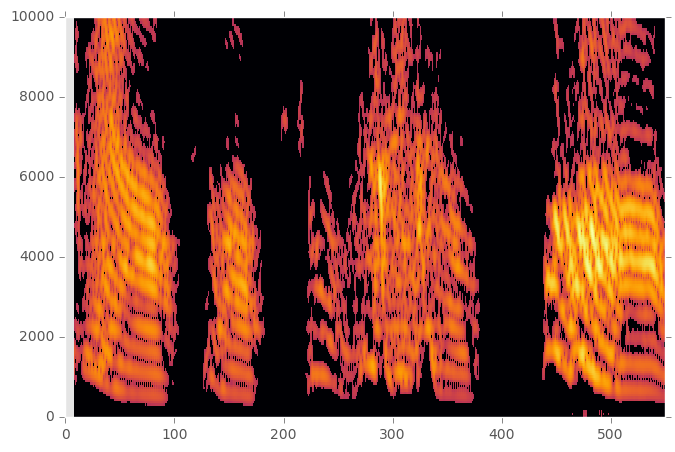

In [4]:
reload(sp)
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

(<matplotlib.figure.Figure at 0x7fbede247d50>,
 <matplotlib.axes._axes.Axes at 0x7fbee0bf1890>)

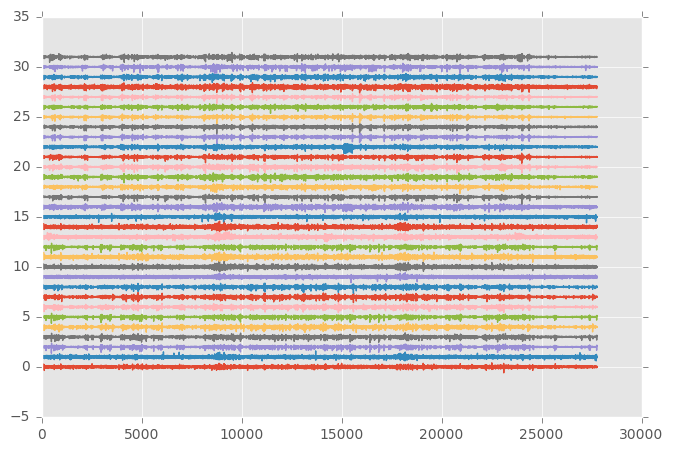

In [5]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 29
#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float, chan_list=neural_chans)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, chan_list = h5d.chan_list, segment=[start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot()

In [6]:
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

# WARNING, NEED A BETTER WAY TO GET THE RMS ACROSS A DAY OF RECORDINGS
rms = h5d.get_rms(window_size_samples=50000, n_windows=10000, rms_func=filter_rms, rms_args = (filter_pars,))

2016-12-14 09:50:53,014 root         INFO     Collecting 71 frames...
2016-12-14 09:50:53,015 root         INFO     Frame 0 ...
2016-12-14 09:50:53,067 root         INFO     Frame 10 ...
2016-12-14 09:50:53,130 root         INFO     Frame 20 ...
2016-12-14 09:50:53,191 root         INFO     Frame 30 ...
2016-12-14 09:50:53,248 root         INFO     Frame 40 ...
2016-12-14 09:50:53,305 root         INFO     Frame 50 ...
2016-12-14 09:50:53,362 root         INFO     Frame 60 ...
2016-12-14 09:50:53,419 root         INFO     Frame 70 ...


2016-12-14 12:51:51,723 root         INFO     Collecting 71 frames...
2016-12-14 12:51:51,725 root         INFO     Frame 0 ...
2016-12-14 12:51:51,841 root         INFO     Frame 10 ...


[ 185.72938156  233.1562935   259.50967533  262.14104027  317.81777359
  257.65131022  321.84154547  277.1758899   268.22102395  239.47731361
  174.09596154  197.00646442  244.51594292  225.70776533  180.77793811
  246.63903535  239.48345027  319.18156328  273.25424592  289.08655382
  299.58146922  307.84046106  240.68714188  272.30982096   93.78957373
  276.38705717  281.55086416  289.39559469  161.58304303  274.51306859
  279.59957591  289.00133249]


2016-12-14 12:51:51,928 root         INFO     Frame 20 ...
2016-12-14 12:51:52,003 root         INFO     Frame 30 ...
2016-12-14 12:51:52,065 root         INFO     Frame 40 ...
2016-12-14 12:51:52,128 root         INFO     Frame 50 ...
2016-12-14 12:51:52,190 root         INFO     Frame 60 ...
2016-12-14 12:51:52,253 root         INFO     Frame 70 ...


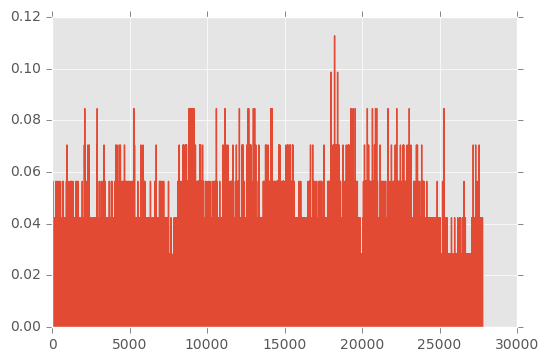

In [9]:
# Collect all the spikes (the support vector)

spike_thresh = 2.5
thresh = rms*spike_thresh
print(thresh)

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

[fr.apply_filter(sp.apply_butter_bandpass, filter_pars) for fr in all_frames]
all_spk_arr = collect_all_spk_arr(all_frames, thresh)
#all_spk_arr = np.stack(all_spk_lst, axis=0)
plt.plot(all_spk_arr.mean(axis=0)[:,0])

(<matplotlib.collections.PathCollection at 0x7fbecb6024d0>,
 <matplotlib.axes._axes.Axes at 0x7fbed00899d0>)

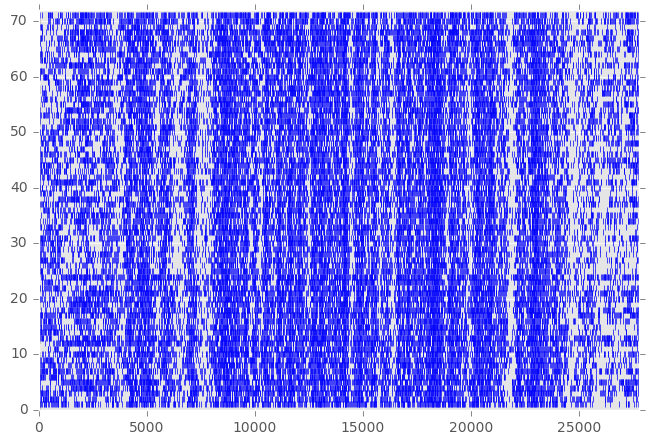

In [10]:
all_spk_arr.shape
bp.plot_raster(all_spk_arr[:,:,7])

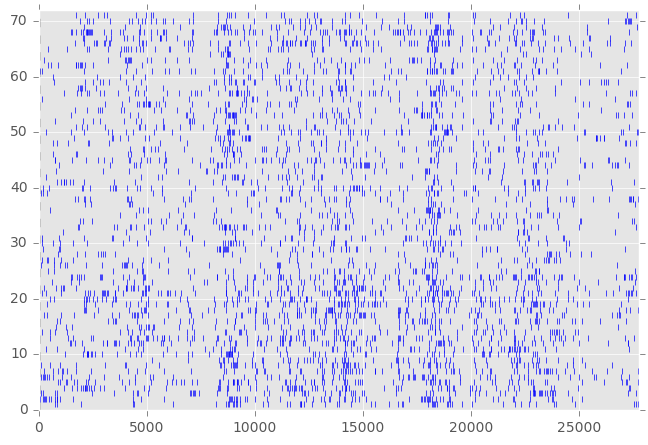

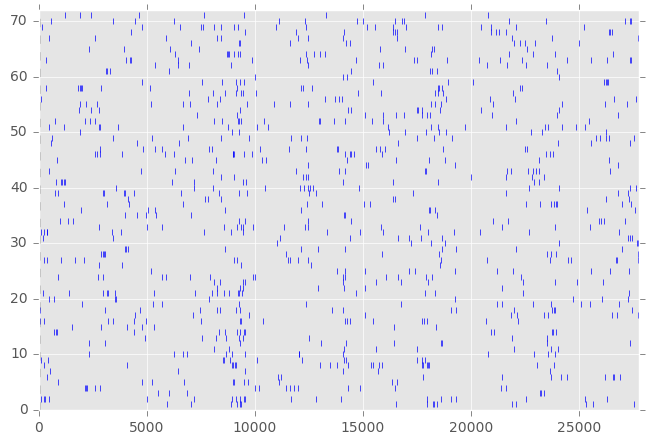

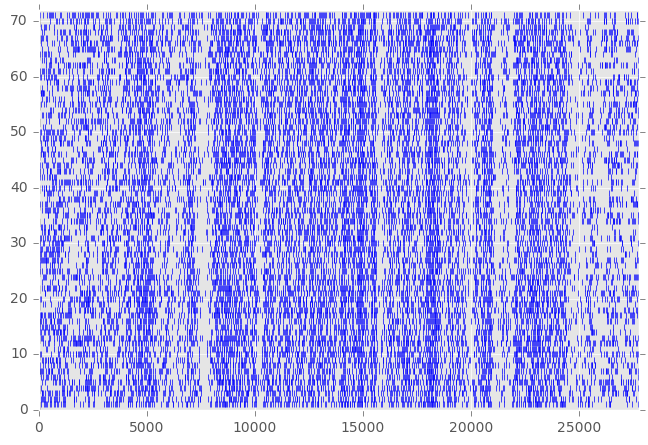

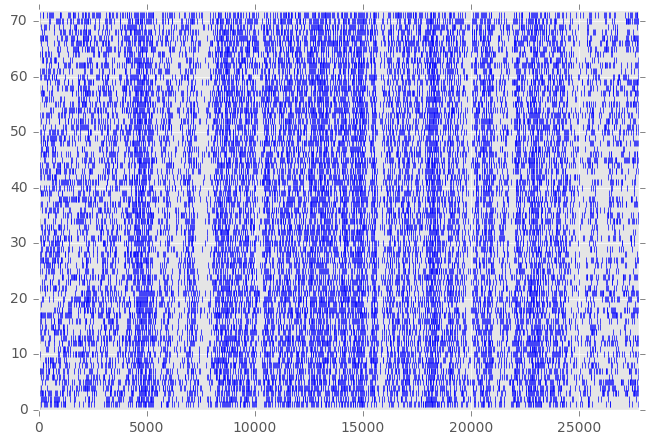

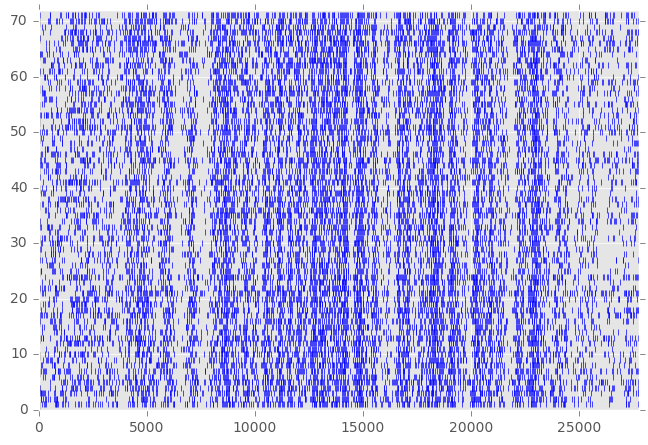

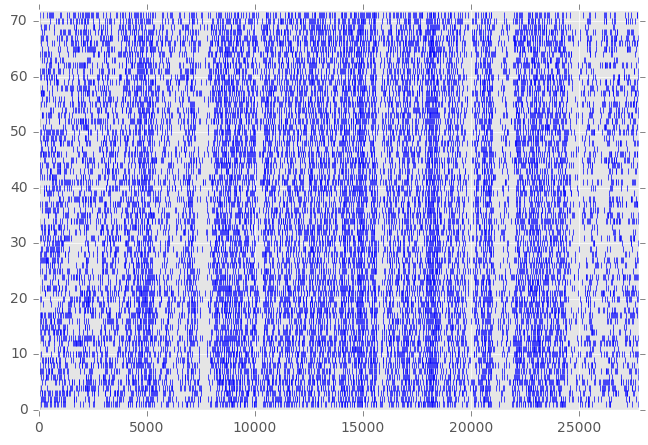

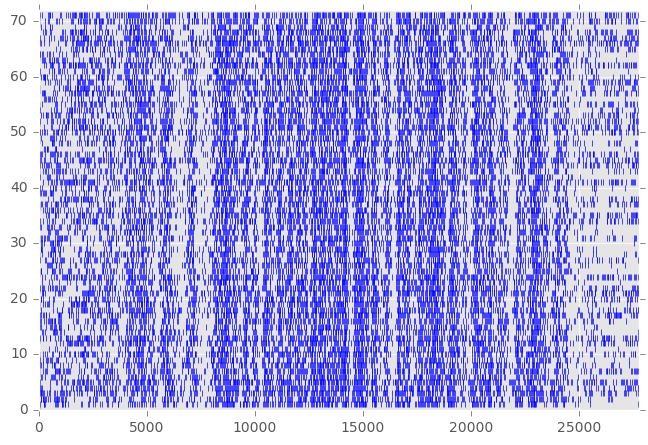

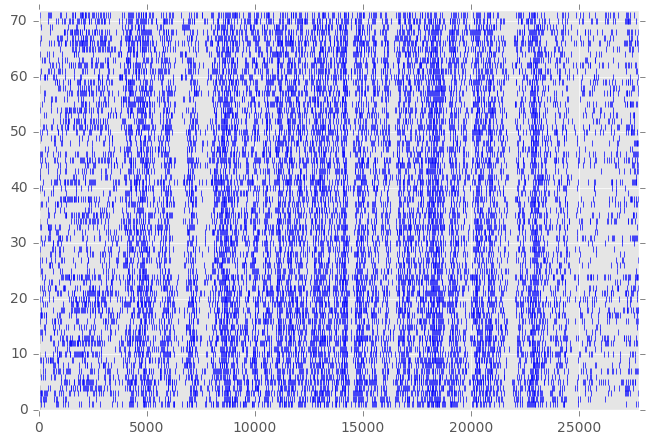

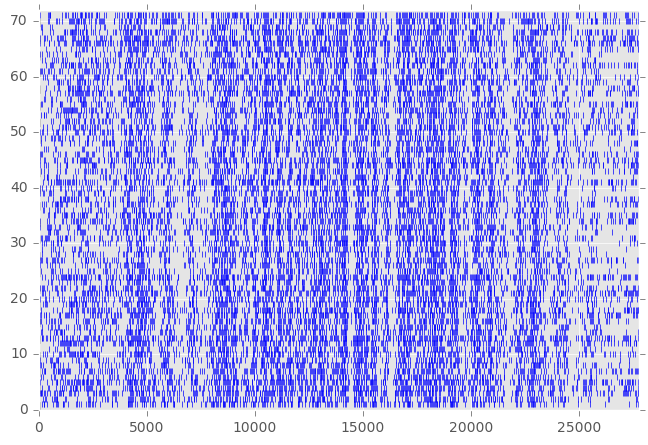

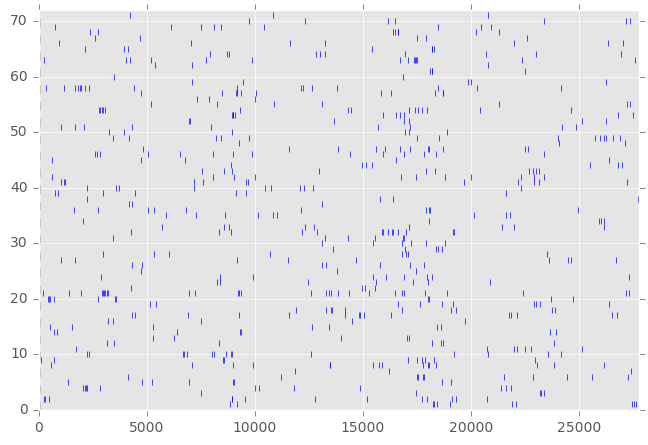

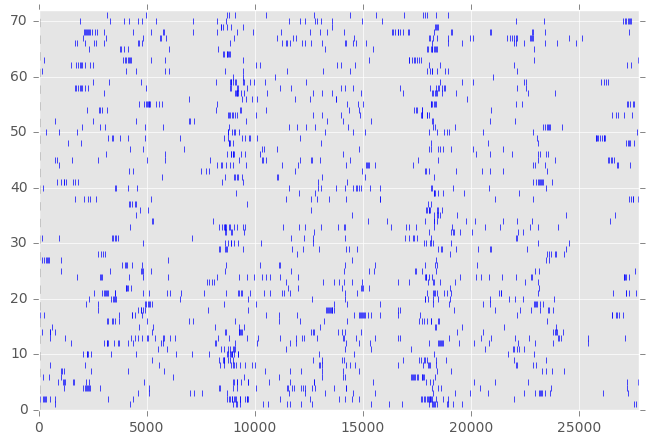

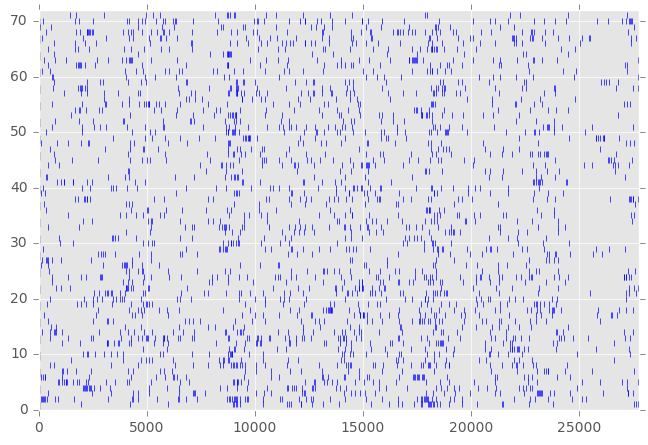

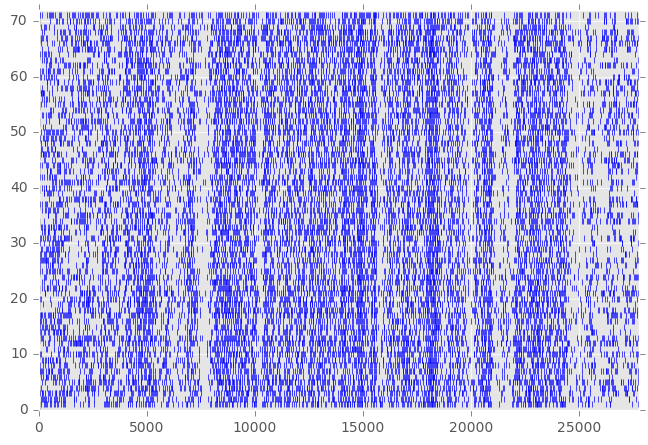

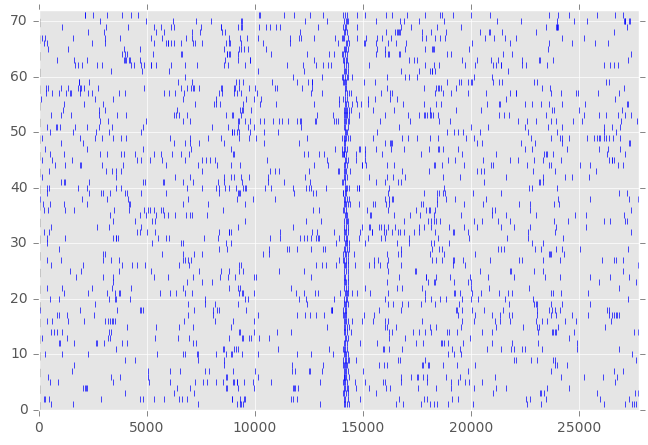

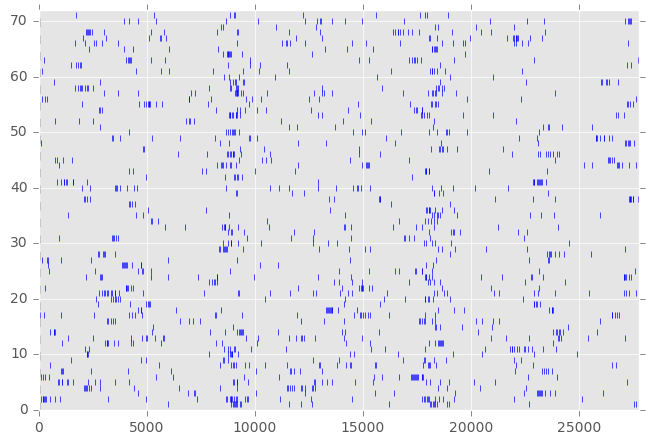

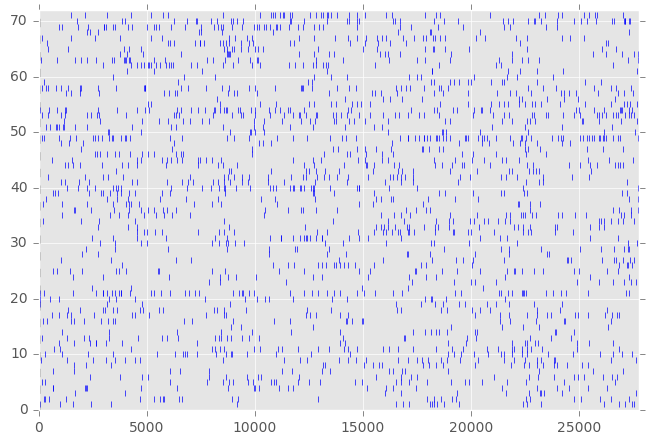

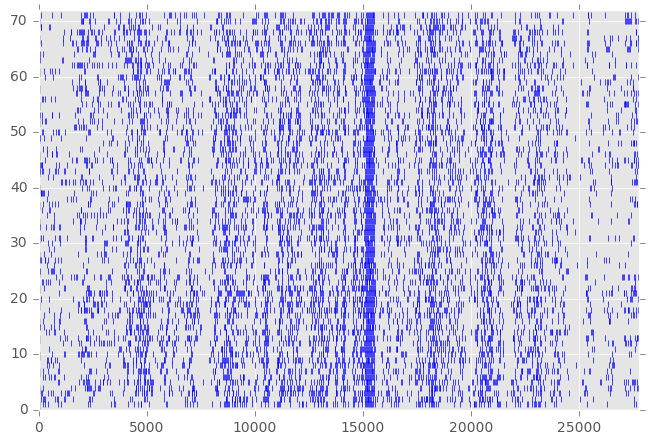

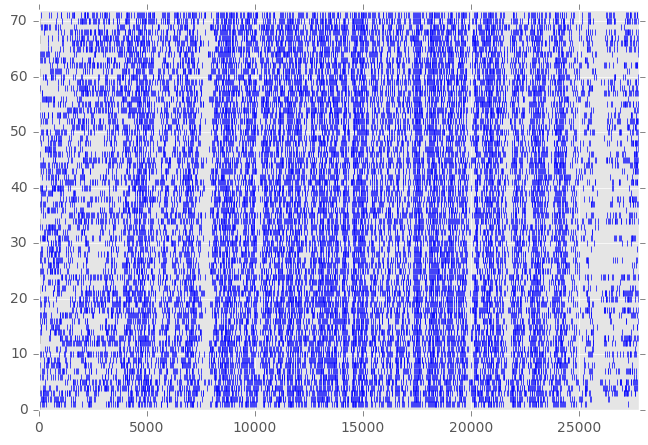

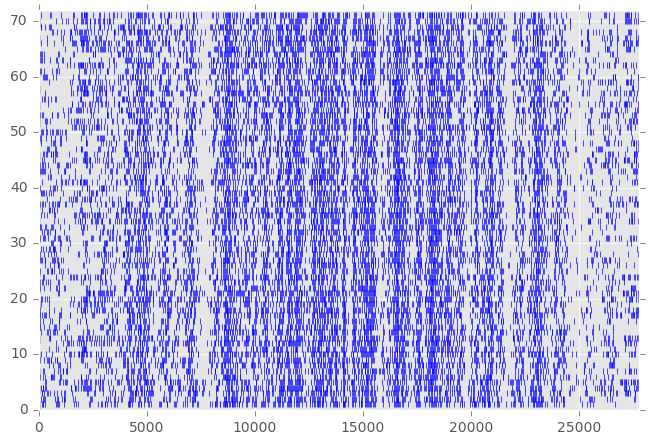

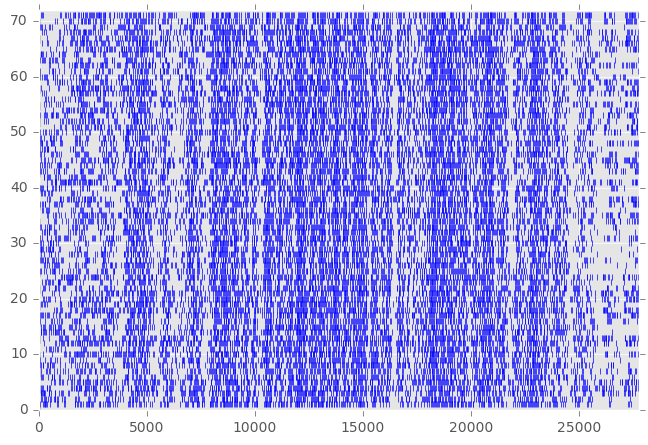

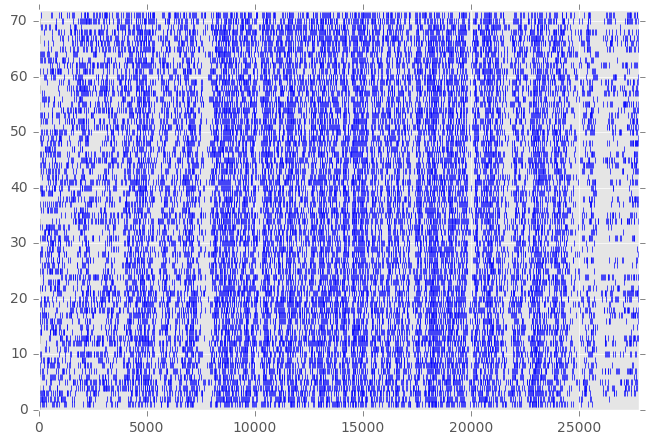

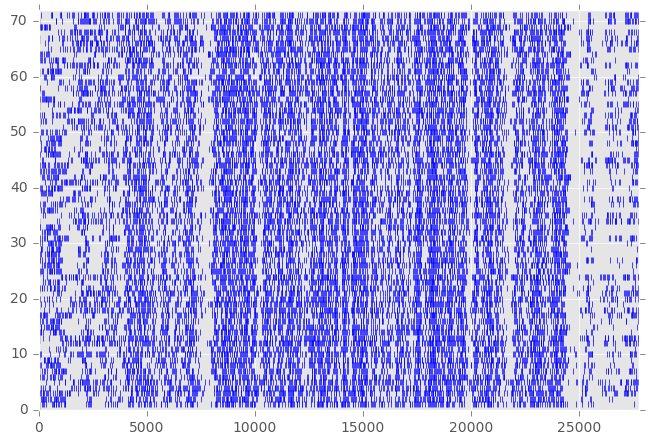

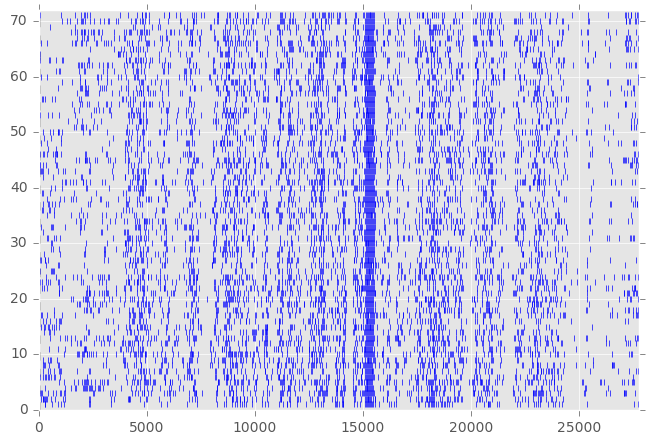

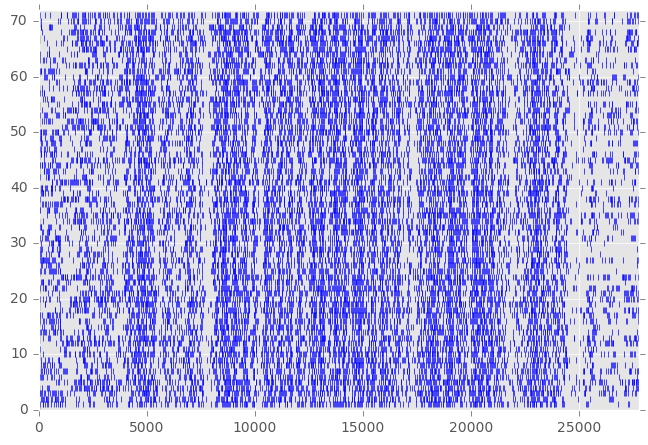

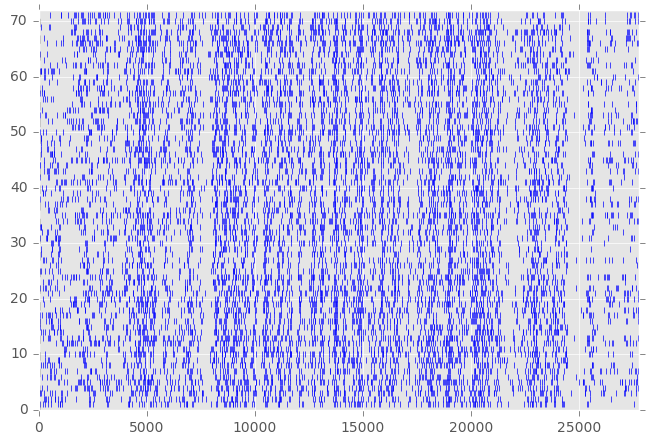

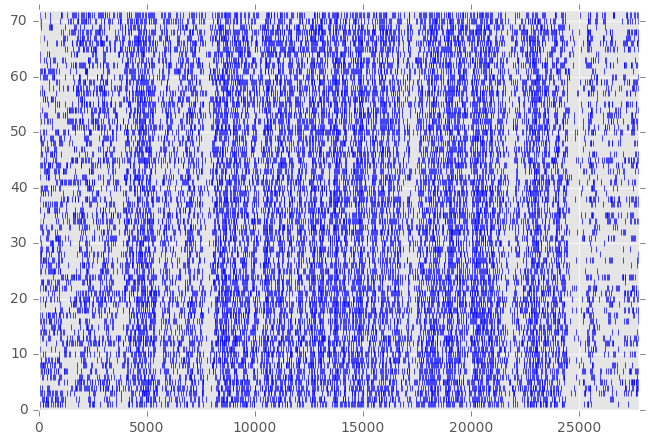

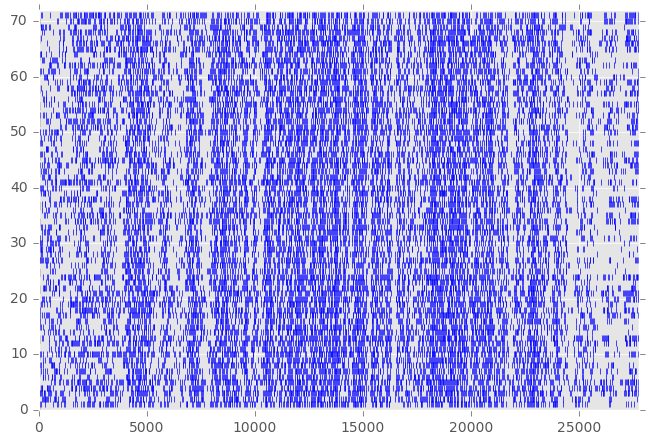

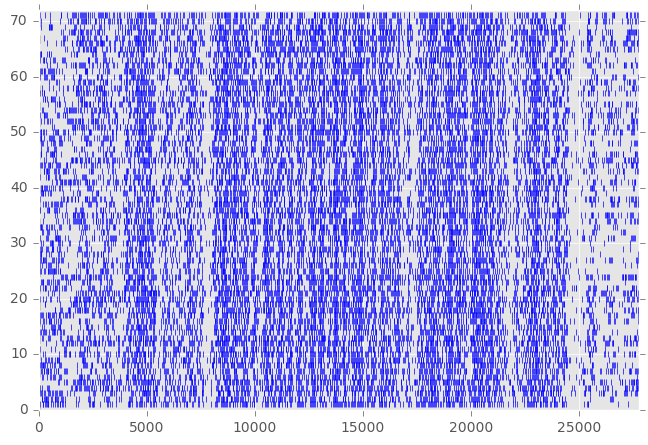

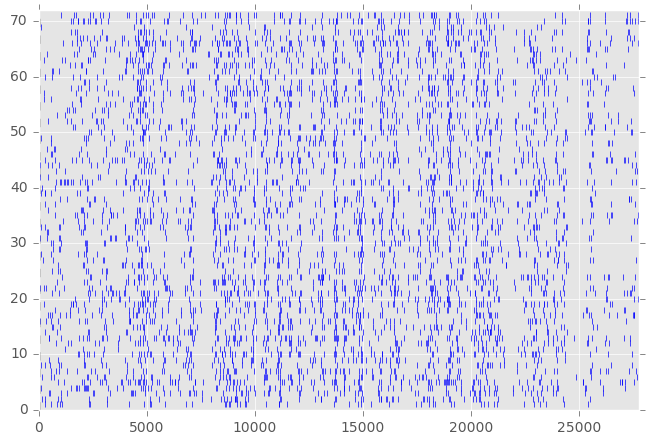

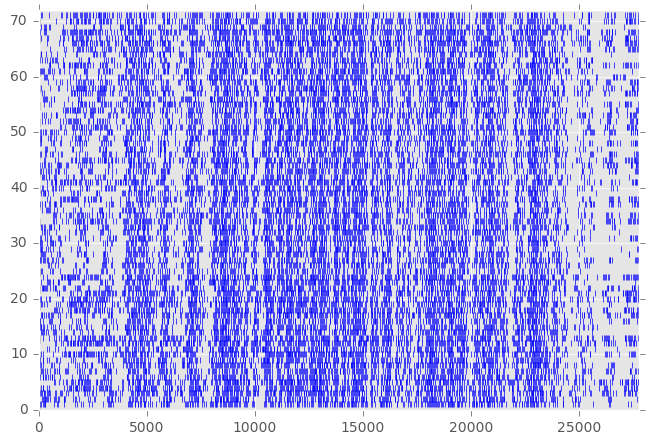

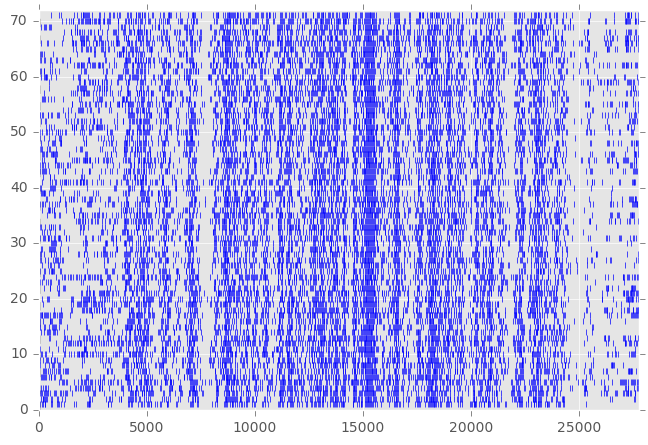

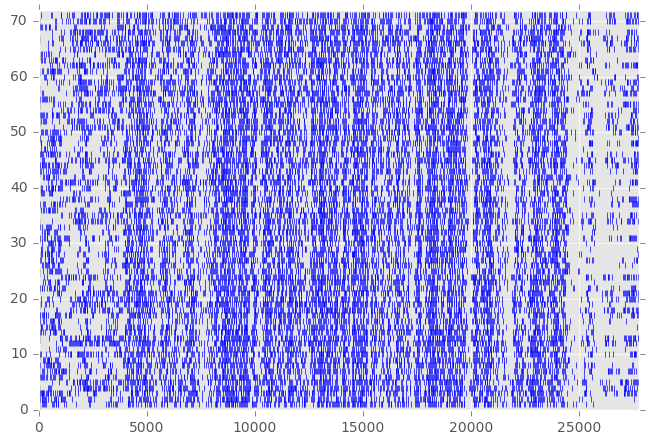

In [18]:
spike_thresh = 4.5
thresh = rms*spike_thresh
all_spk_arr = collect_all_spk_arr(all_frames, thresh, min_dist=20)
for i in range(neural_chans.size):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    bp.plot_raster(all_spk_arr[:,:,i])

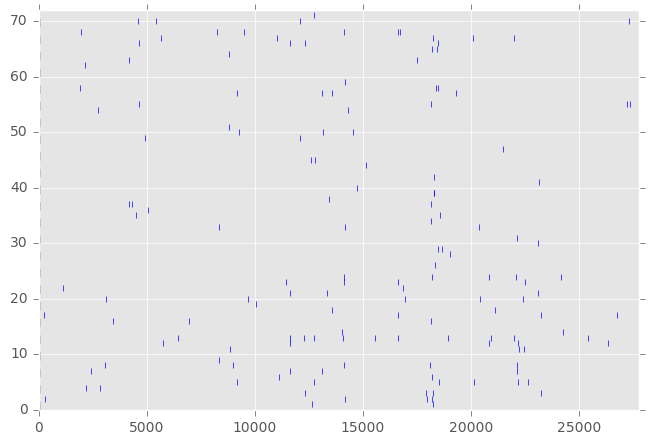

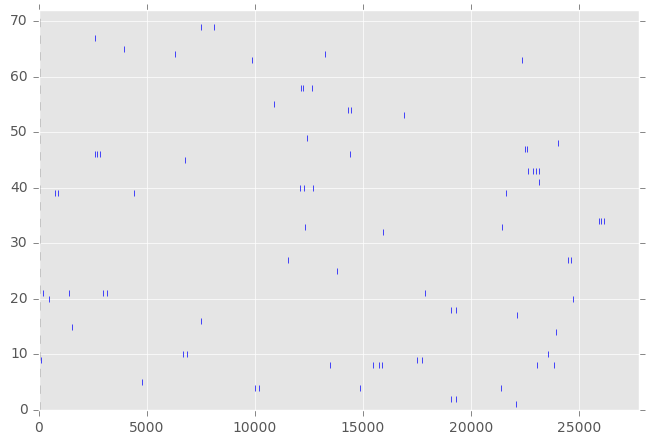

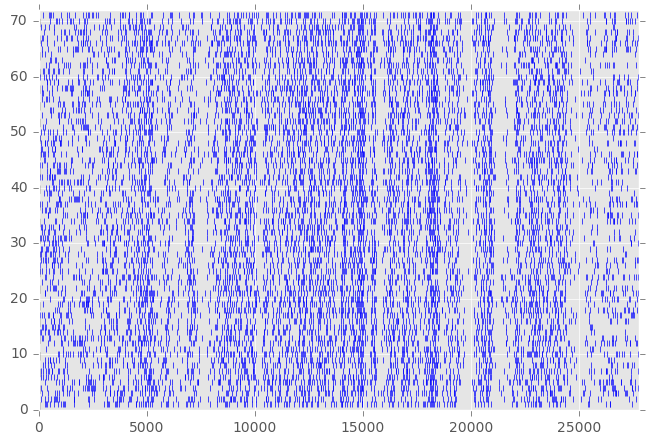

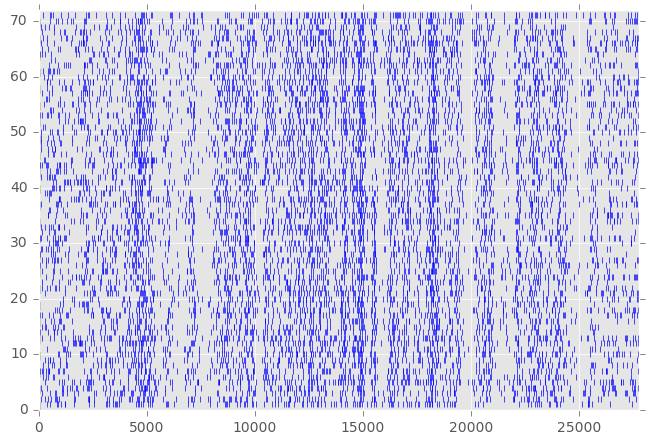

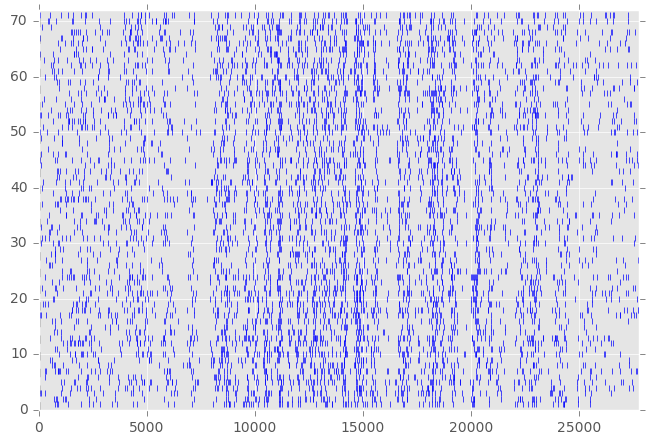

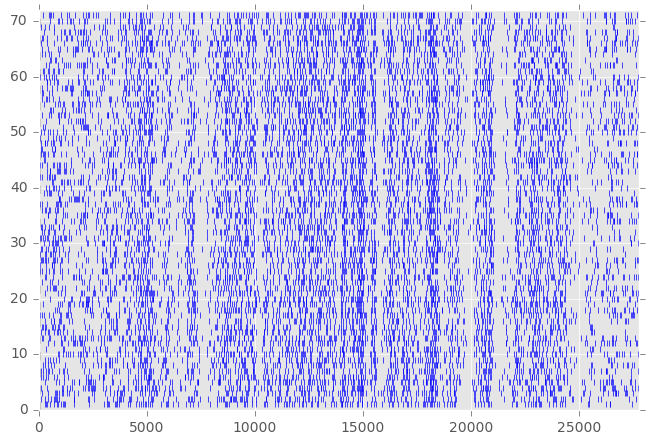

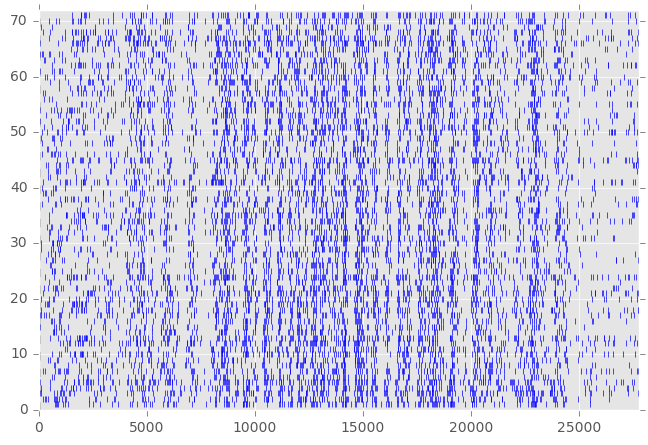

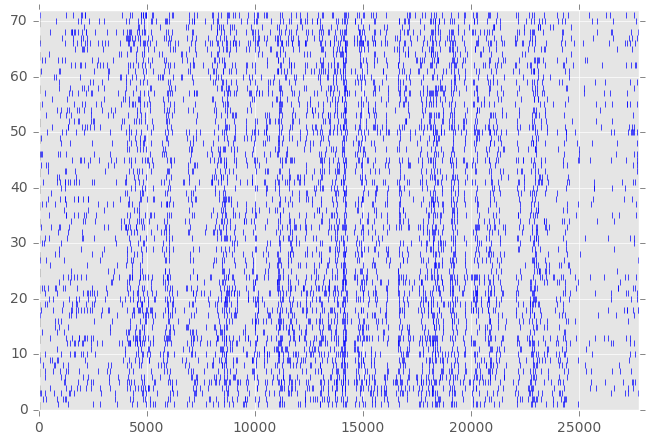

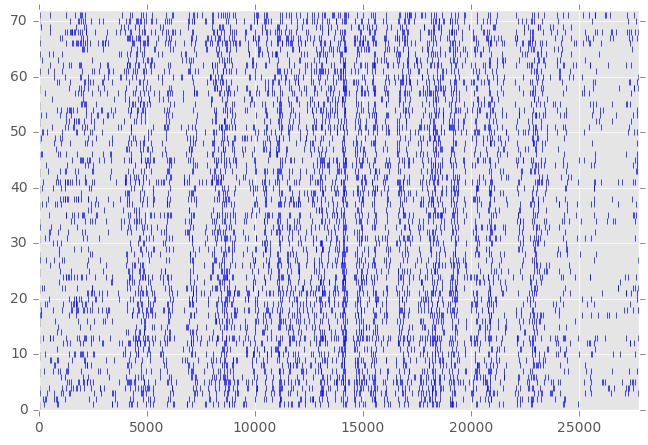

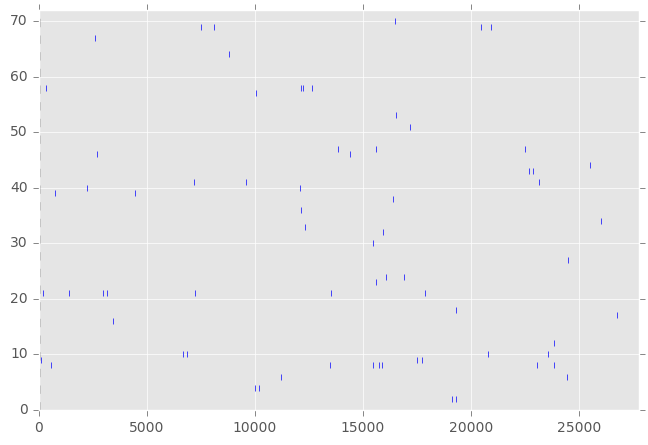

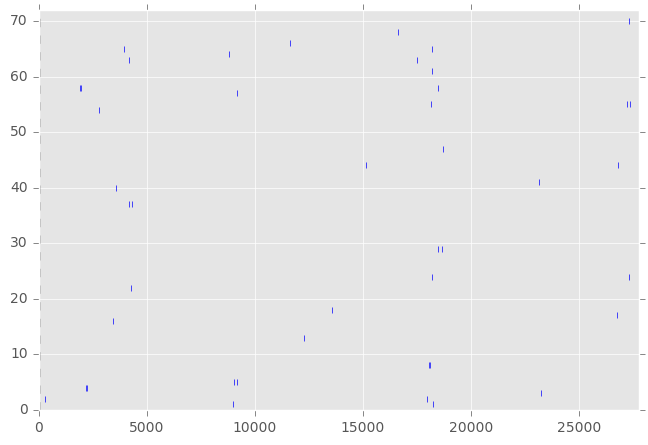

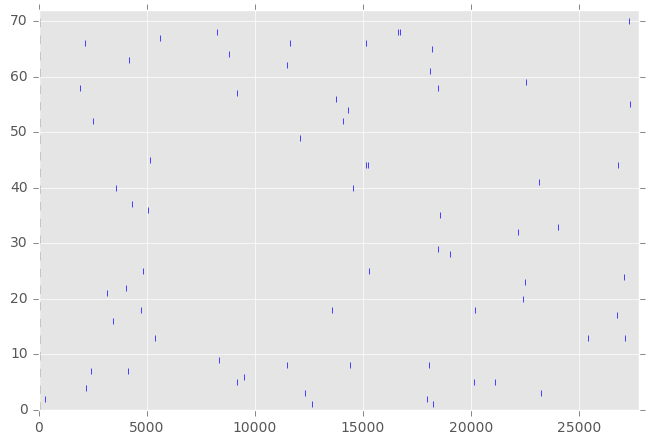

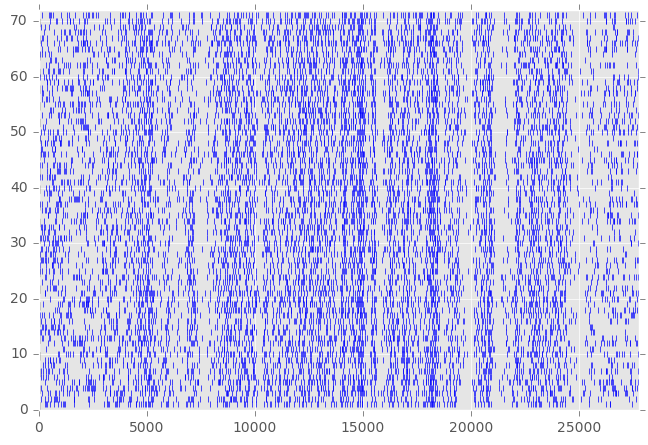

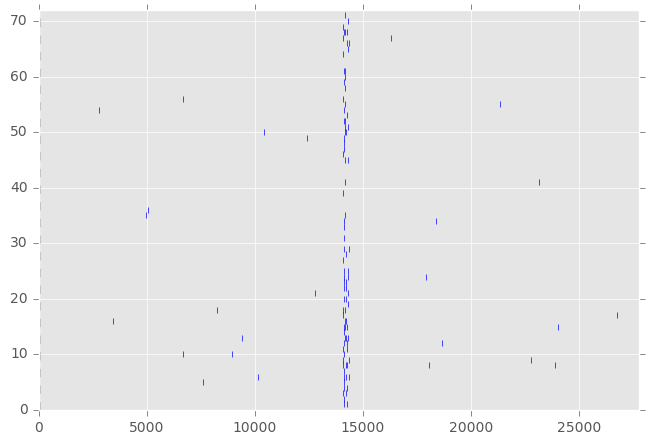

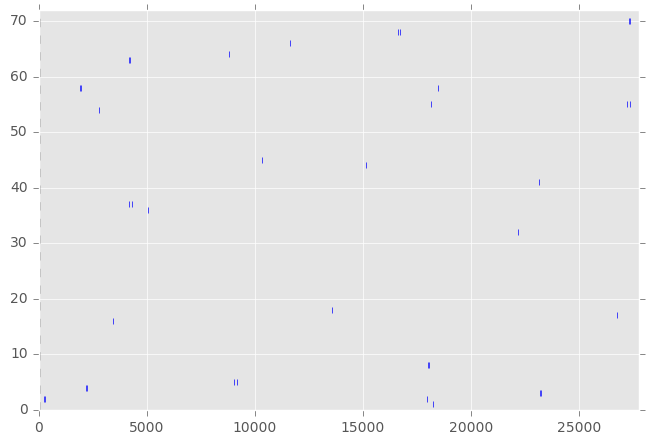

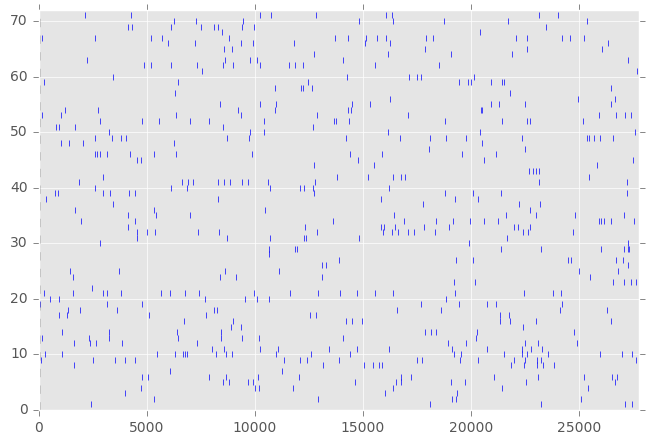

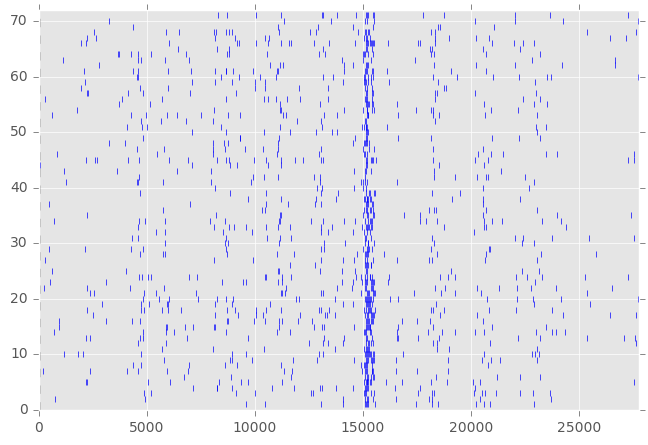

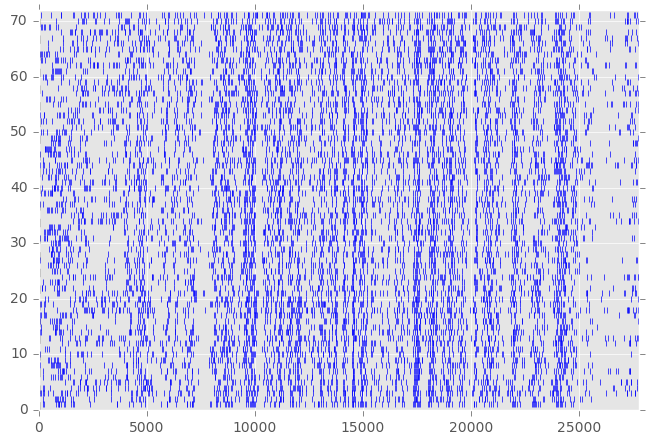

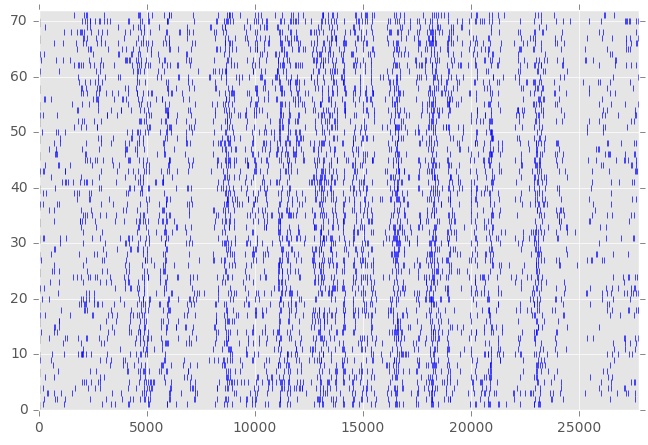

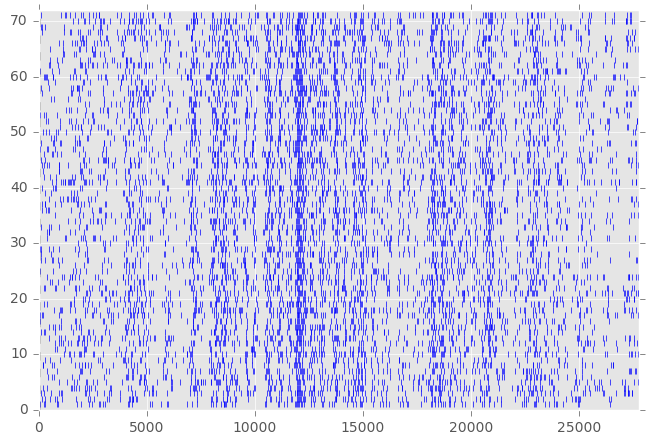

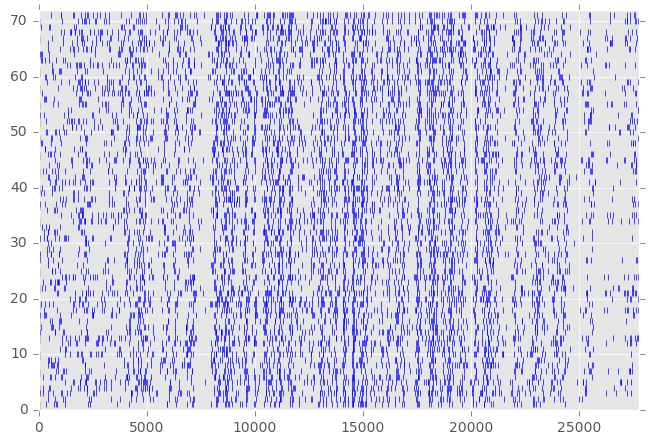

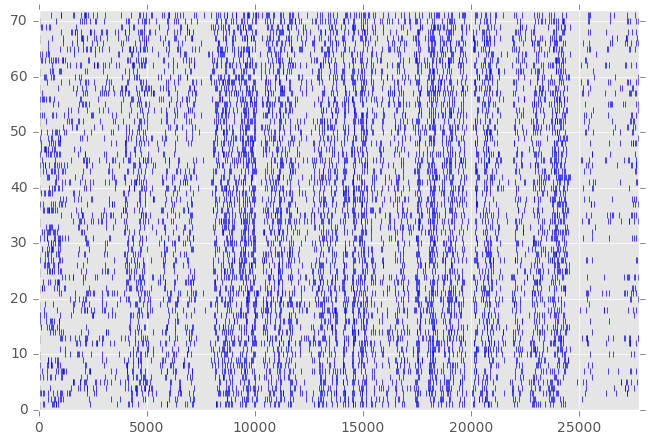

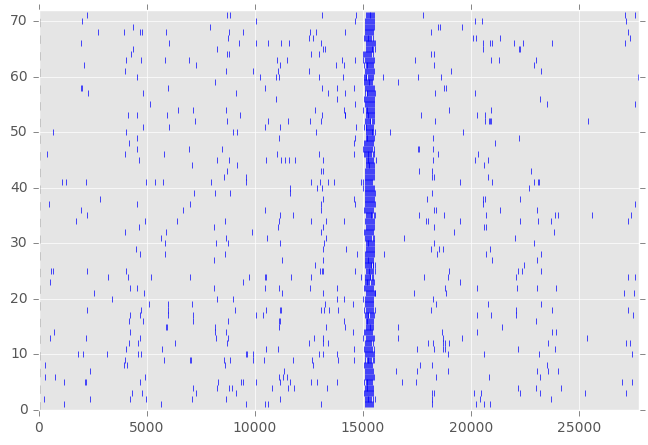

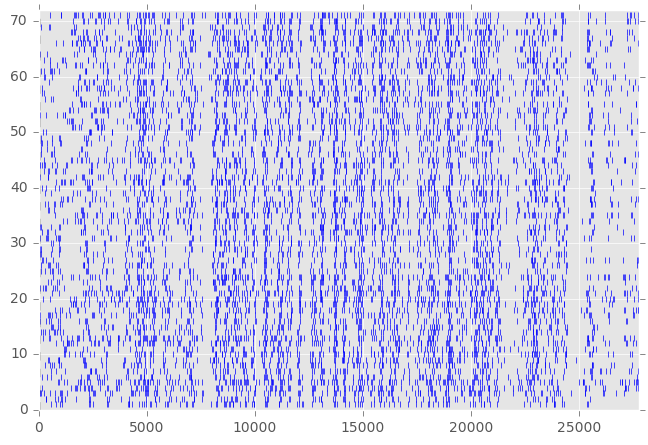

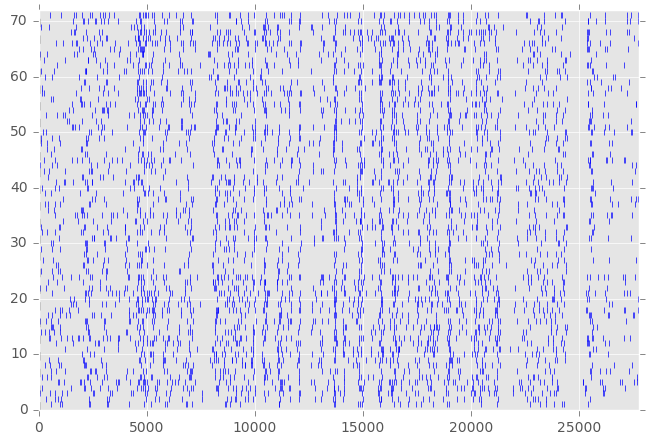

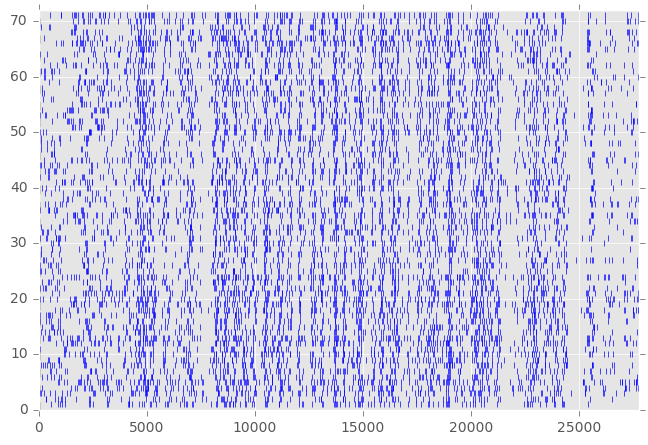

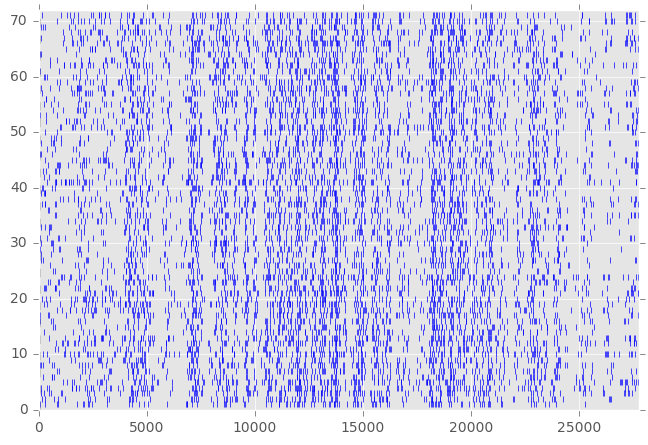

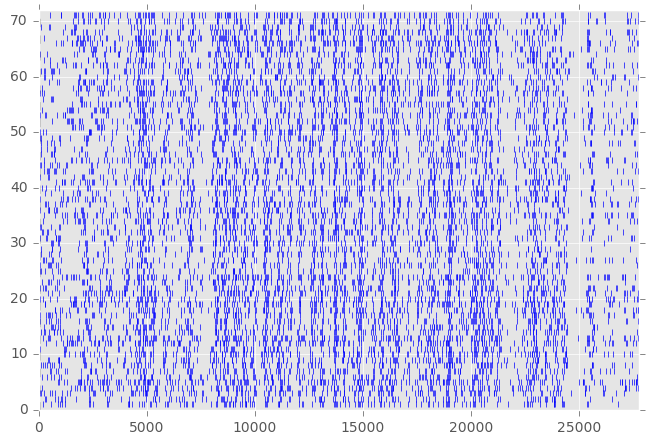

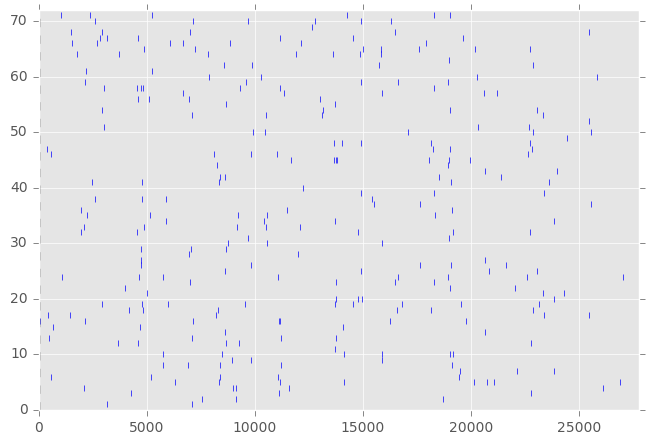

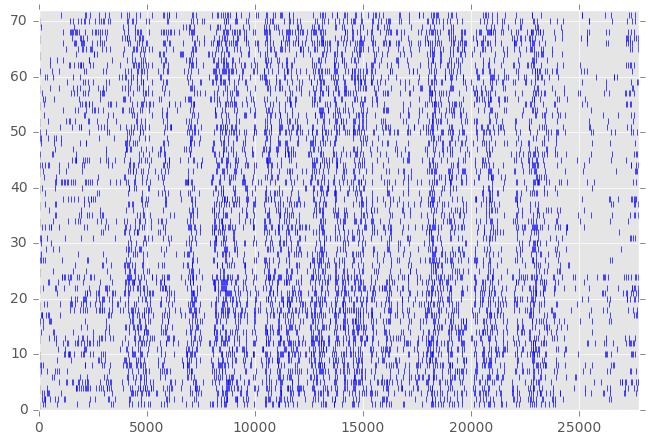

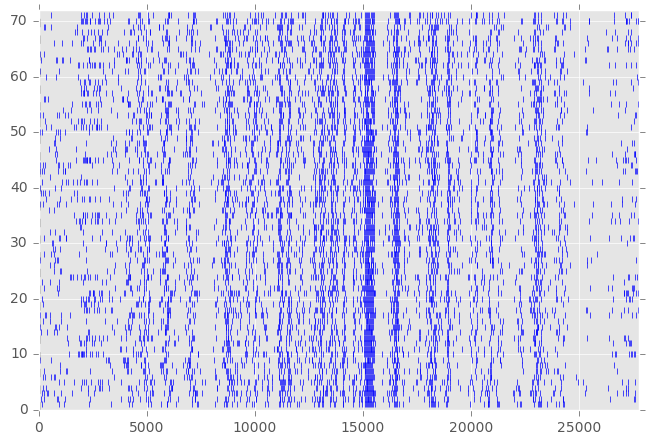

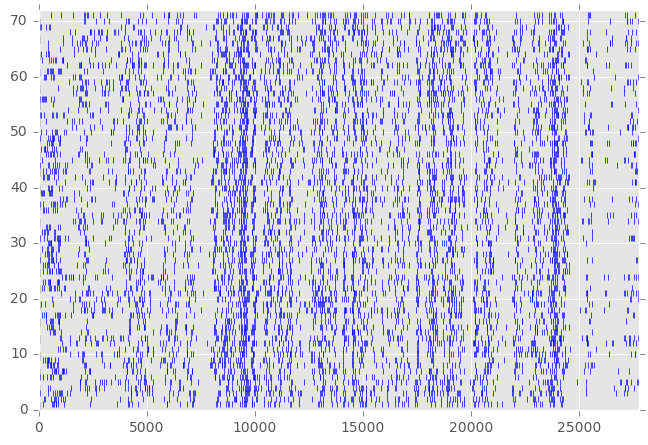

In [12]:
spike_thresh = 4.5
thresh = rms*spike_thresh
all_spk_arr = collect_all_spk_arr(all_frames, thresh, min_dist=20)
for i in range(neural_chans.size):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    bp.plot_raster(all_spk_arr[:,:,i])


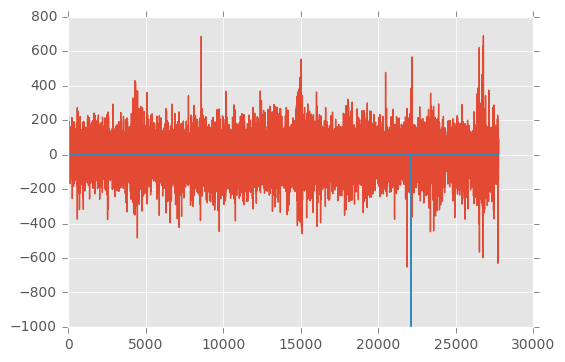

In [17]:
fr_n = 16
ch_n = 1
plt.plot(all_frames[fr_n].data[:, ch_n])
plt.plot(all_spk_arr[fr_n,:,ch_n]*(-1000));

In [13]:
starts

array([  1163019,   1089649,   1066718,   1140048,   1044059,    800016,
          776742,   1071350,    863317,    839863,   1095769,   1048085,
          753735,    425433,    329445,    255790,    232464,    402378,
          475115,    306252,    209595,   6556745,   6580171,   6533693,
       251220564, 251047935, 298815519, 261064431, 250983424, 408881367,
       250960123, 269879472,    702573, 270254686, 251197198, 269959700,
       269855887, 251024491, 298839264, 408792242, 186201666, 433160231,
       308791969, 408769005, 250937166, 270278000, 308815563, 260968317,
       433091787,    679131, 298792325, 269936195, 433068453, 433216105,
       269832823, 270301690, 408746044, 433136712, 261041137, 186225442,
          850097, 308768936, 333453510, 186249508, 408858147,    656046,
       260945130,    826825, 433240010, 333430373, 433045425])

In [145]:
def find_silent(sup_vec):
    silent_list = np.array([any(~(sup_vec[i,:,:].any(axis=0))) for i in range(sup_vec.shape[0])])
    return silent_list

def support_vector_from_raw(starts, recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=10, s_f=30000, history_bins=1, no_silent=True):

    print starts.shape
    bin_size_samples = int(bin_size * s_f / 1000.)
    len_bin = int(len_samples / bin_size_samples)
    len_ms = int(len_bin * bin_size)
    history_samples = history_bins * bin_size_samples
    span_ms = len_ms + bin_size * history_bins
    span_samples = int(span_ms * s_f / 1000.)

    # logger.info('span_ms = {}'.format(span_ms))
    # logger.info('{} units'.format(len(all_units)))

    all_frames = collect_frames(starts - history_samples,
                                span_samples,
                                s_f,
                                kwd_file,
                                recs,
                                channels)
    
    [fr.apply_filter(sp.apply_butter_bandpass, filter_pars) for fr in all_frames]
    all_spk_arr = collect_all_spk_arr(all_frames, thresholds)
    
    rst_sv = np.stack([bp.col_binned(all_spk_arr[t,:,:].T, bin_size_samples) for t in range(all_spk_arr.shape[0])], 
                      axis=2)
    
    if no_silent:
        good_chans = ~find_silent(rst_sv)
    else:
        good_chans = channels

    return rst_sv[good_chans, :, :]

spike_thresh = 4.5
thresh = rms*spike_thresh
sv=support_vector_from_raw(starts[trials_train], recs[trials_train], m_chunk.samples, neural_chans, thresh, kwd_file)


2016-12-12 19:54:09,872 root         INFO     Collecting 65 frames...
2016-12-12 19:54:09,874 root         INFO     Frame 0 ...
2016-12-12 19:54:09,931 root         INFO     Frame 10 ...
2016-12-12 19:54:09,980 root         INFO     Frame 20 ...
2016-12-12 19:54:10,023 root         INFO     Frame 30 ...
2016-12-12 19:54:10,060 root         INFO     Frame 40 ...


(65,)


2016-12-12 19:54:10,096 root         INFO     Frame 50 ...
2016-12-12 19:54:10,128 root         INFO     Frame 60 ...


In [143]:
~find_silent(sv)
#sv.shape

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

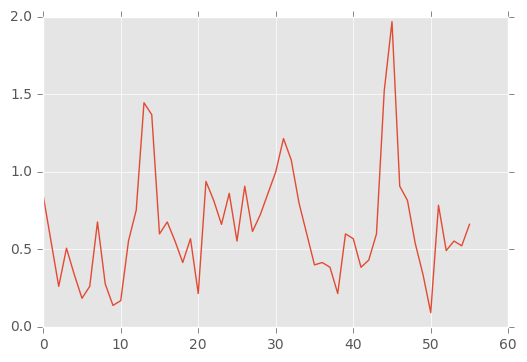

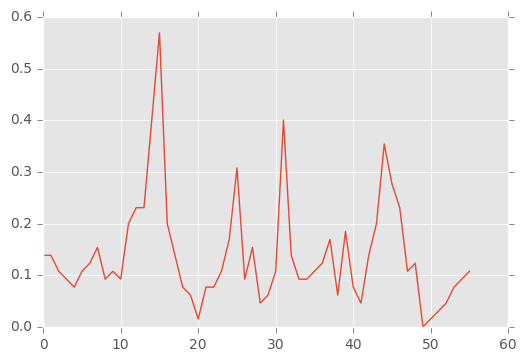

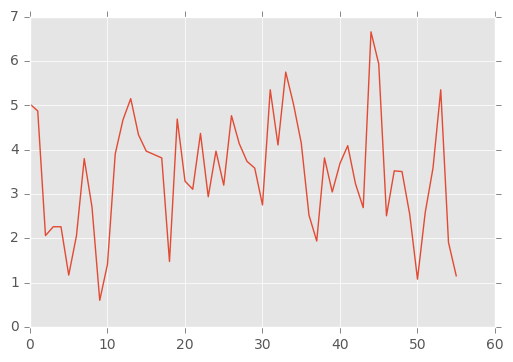

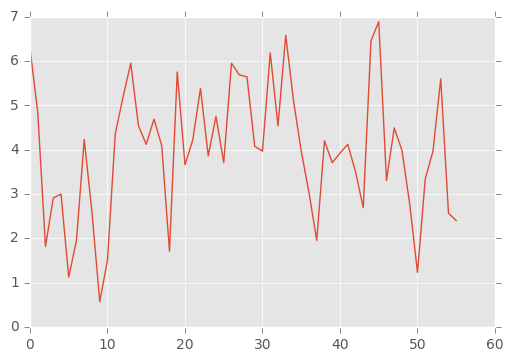

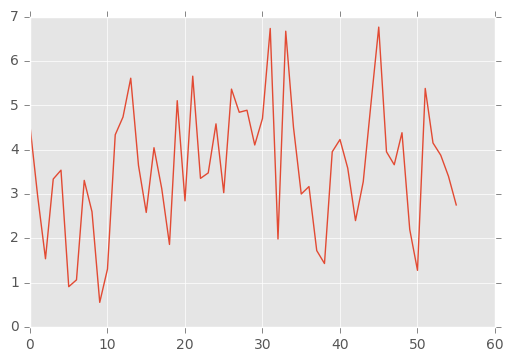

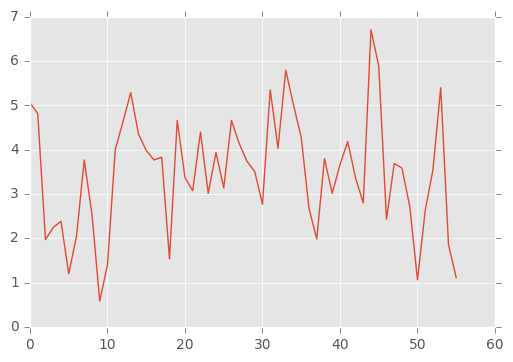

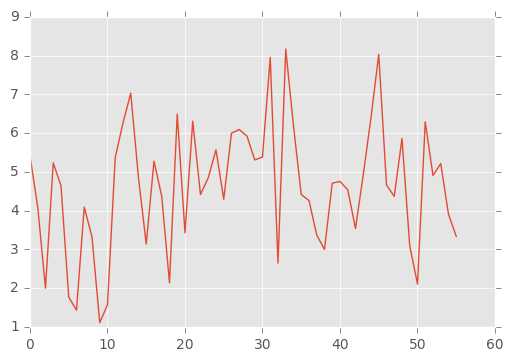

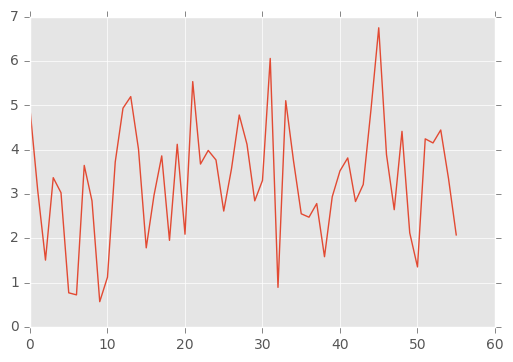

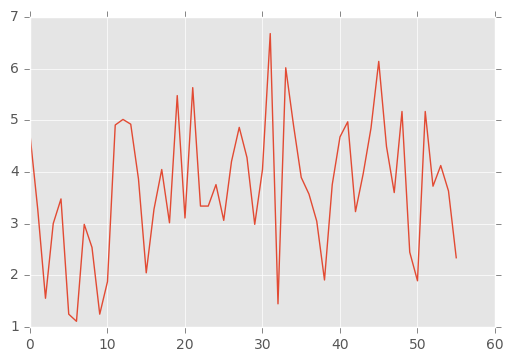

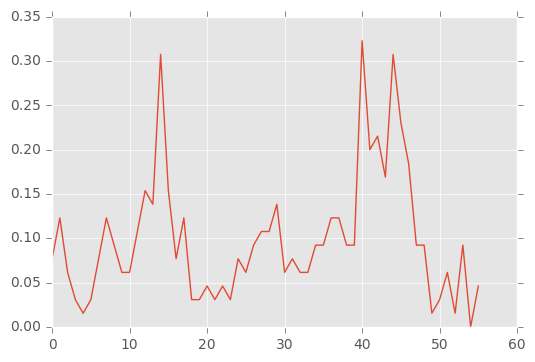

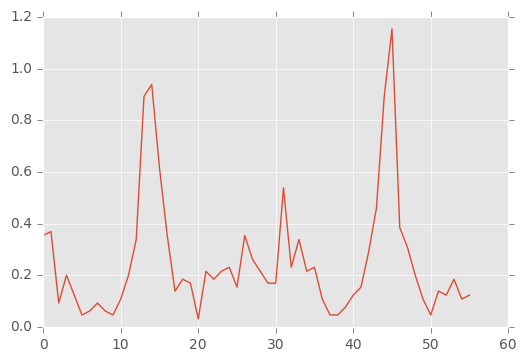

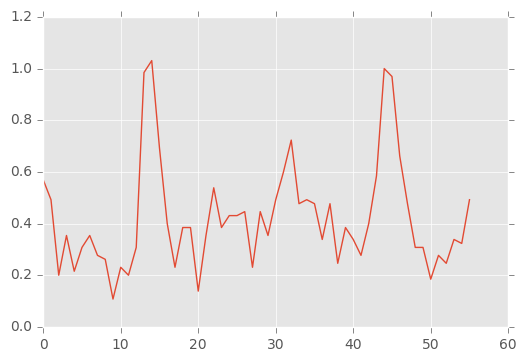

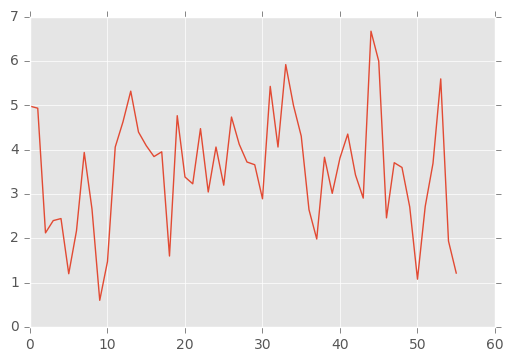

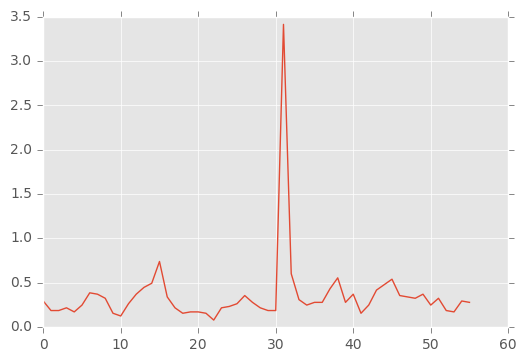

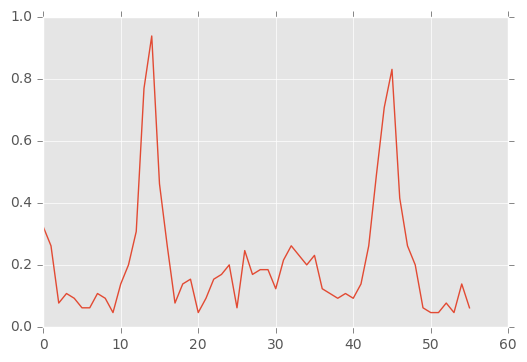

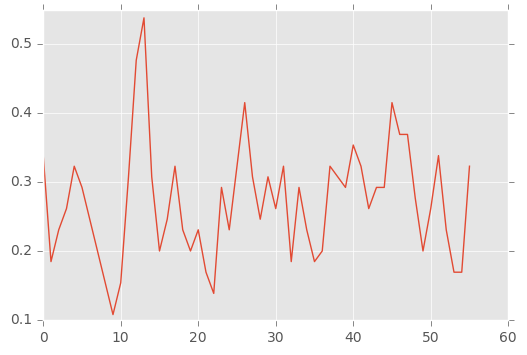

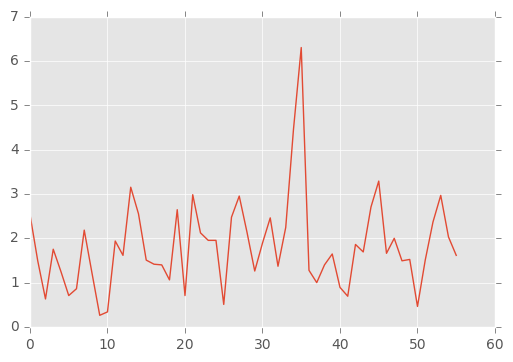

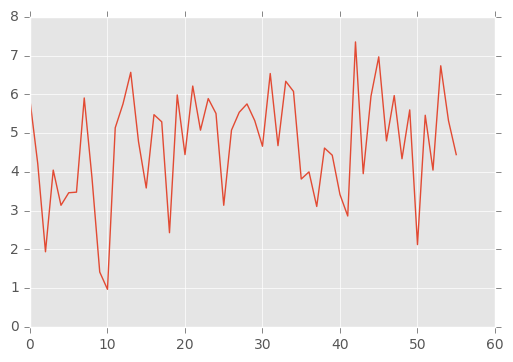

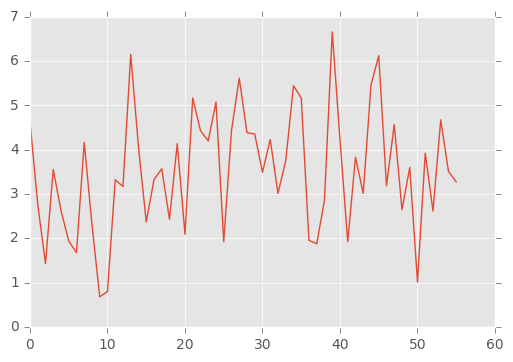

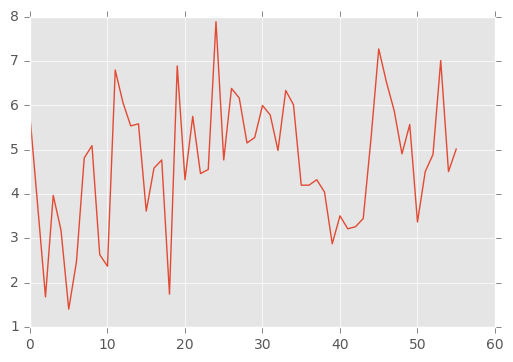

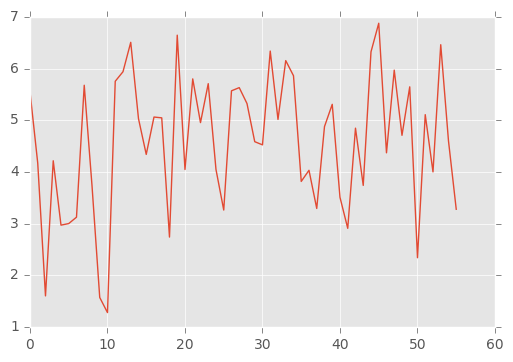

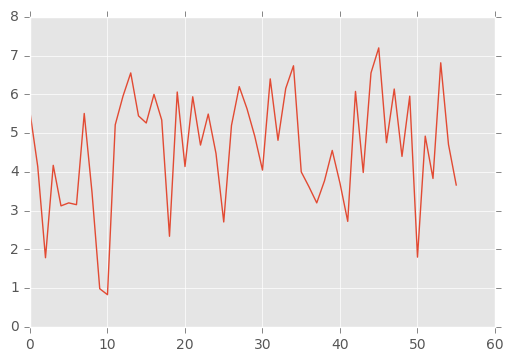

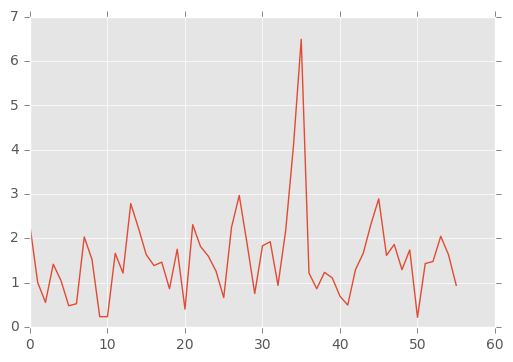

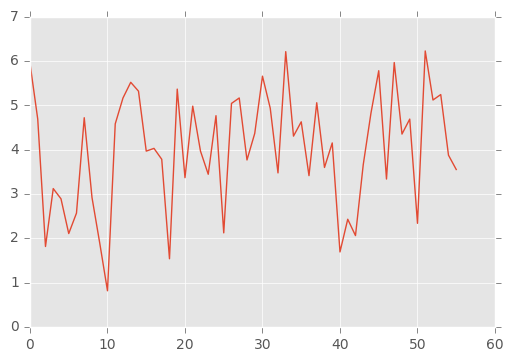

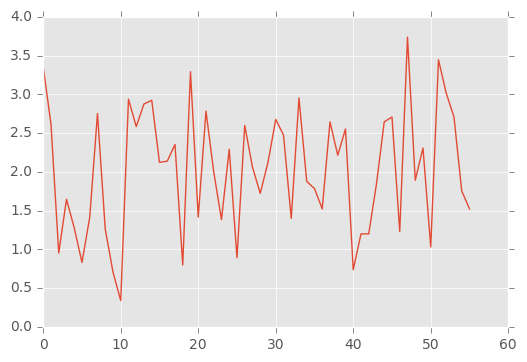

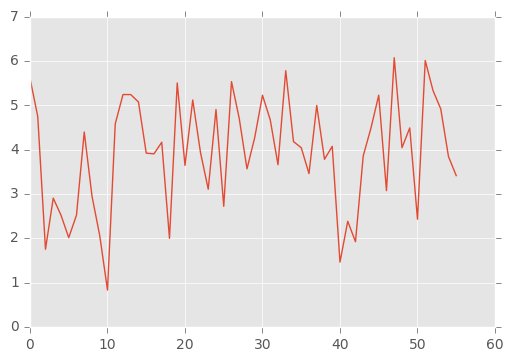

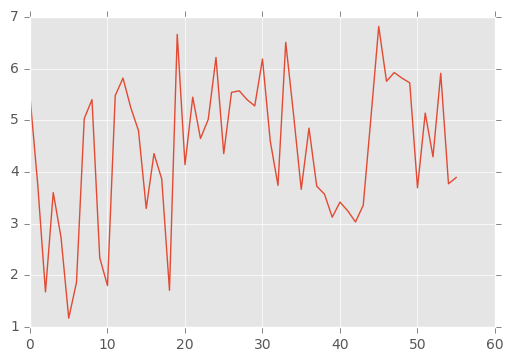

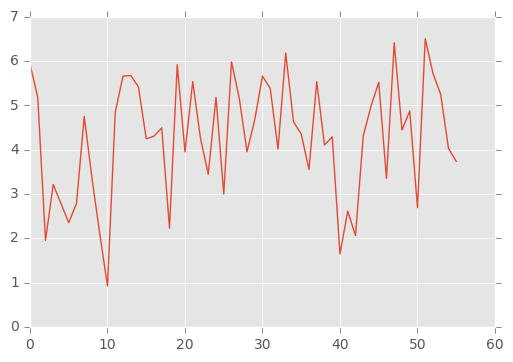

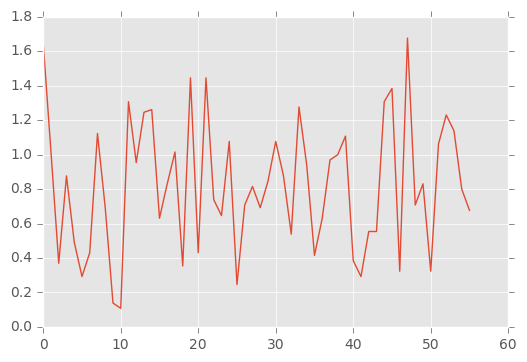

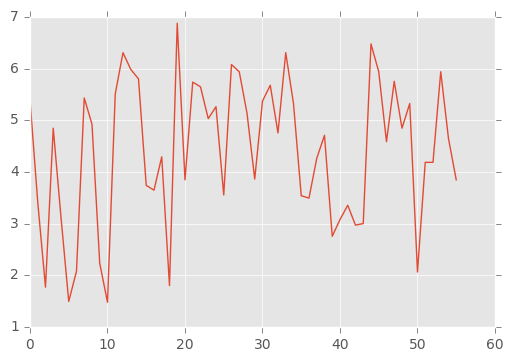

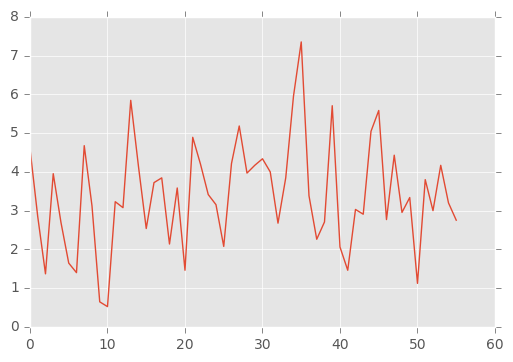

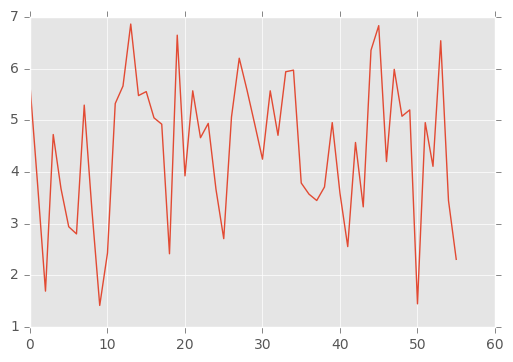

In [146]:
gc_sv = sv[~filter_silent(sv), :,:]
for i in range(gc_sv.shape[0]):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    plt.plot(np.mean(gc_sv[i, :,:], axis=1))

In [19]:
# INTO THE WILD FITTING NOW
def transform_env(x):
    x[x<0] = 0
    return x

def transform_alpha(x):
    x[x<0.15] = 0
    x[x>=.15] = .3
    return x

def transform_beta(x):
    x[x<0] = 0
    return x

def mu_transform_beta(x):
    x[x<0] = 0
    return syn.np_mulog_inv(x, 256)


def linear_fit(channels, thresholds, kwd_file, trial_starts, trial_recs, par_stream, bin_size=10, history_bins=15, s_f=30000):
    bin_size_samples = int(bin_size*s_f/1000.)
    len_samples = par_stream.shape[0]
    model_pars = bp.col_binned(np.array([par_stream]), bin_size_samples)/bin_size_samples

        
    s_v = support_vector_from_raw(trial_starts, trial_recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=bin_size, s_f=s_f, history_bins=history_bins+1, no_silent=True)
    
    target = np.tile(model_pars, trial_starts.size).reshape(trial_starts.size, -1)
    logger.info('sv shape {0}, target shape {1}'.format(s_v.shape, target.shape))
    return ld.fit_kernel(s_v, target, history_bins+1)

def linear_predict(channels, thresholds, kwd_file, trial_starts, trial_recs, len_samples, kernel, 
                   bin_size=10, 
                   history_bins=15, 
                   s_f=30000,
                   no_silent=False):
    
    s_v = support_vector_from_raw(trial_starts, trial_recs, len_samples, channels, thresholds, kwd_file,
                            bin_size=bin_size, s_f=s_f, history_bins=history_bins+1, no_silent=no_silent)
    
    logger.info('kernel shape {0}, sv_shape {1}, len_samples {2}'.format(kernel.shape, s_v.shape, len_samples))  
    return ld.kernel_predict(s_v, kernel)



In [20]:
# Try a fit
fns = et.file_names(bird, '002')
all_aligned = np.load(os.path.join(fns['folders']['stim'], 'par_stream_aligned.npy'))
alpha = all_aligned[:, 0]
beta = all_aligned[:, 1]
env = all_aligned[:, 2]

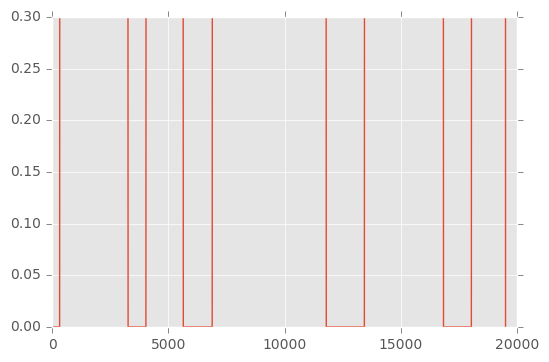

In [21]:
plt.plot(alpha)

In [22]:
starts[trials_train].shape


NameError: name 'trials_train' is not defined

In [23]:
import spike_detect_aux as aux


2016-12-14 13:16:07,190 spike_detect_aux INFO     Computer: passaro
2016-12-14 13:16:07,196 spike_detect_aux INFO     Fitting a kernel
2016-12-14 13:16:07,198 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-14 13:16:07,200 spike_detect_aux INFO     Collecting 65 frames...
2016-12-14 13:16:07,202 spike_detect_aux INFO     Frame 0 ...
2016-12-14 13:16:07,291 spike_detect_aux INFO     Frame 10 ...
2016-12-14 13:16:07,360 spike_detect_aux INFO     Frame 20 ...
2016-12-14 13:16:07,421 spike_detect_aux INFO     Frame 30 ...
2016-12-14 13:16:07,474 spike_detect_aux INFO     Frame 40 ...
2016-12-14 13:16:07,523 spike_detect_aux INFO     Frame 50 ...
2016-12-14 13:16:07,586 spike_detect_aux INFO     Frame 60 ...
2016-12-14 13:16:12,899 spike_detect_aux INFO     sv shape (30, 87, 65), target shape (65, 60)
2016-12-14 13:16:13,282 spike_detect_aux INFO     k shape (841,)
2016-12-14 13:16:13,283 spike_detect_aux INFO     Convolving a kernel
2016-12-14 13:16:13,284 spi

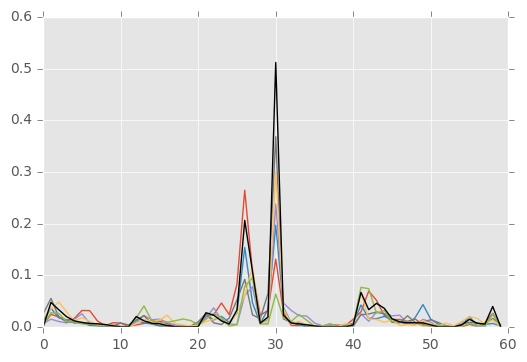

In [32]:
reload(aux)
from bci import synthetic as syn

par_stream = syn.np_mulog(beta)
from decoder import linear as ld
trials_train = np.arange(65)
trials_test = np.arange(65,71)
b_s = 11
h_b = 27
thresh_factor = 5.5
thresh = rms*thresh_factor
chans = np.arange(thresh.size)
fitted_kernel, fitted_chans = aux.linear_fit(chans, thresh, kwd_file, starts[trials_train], recs[trials_train], par_stream, 
                       bin_size=b_s, history_bins=h_b)
#fitted_kernel.flatten()
par_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], par_stream.size, fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

plt.plot(syn.np_mulog_inv(aux.transform_beta(par_pred)).T);
plt.plot(syn.np_mulog_inv(bp.col_binned(par_stream.reshape(1, -1), b_s*30).T/(b_s*30)), 'k');

In [319]:
nice_alpha = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

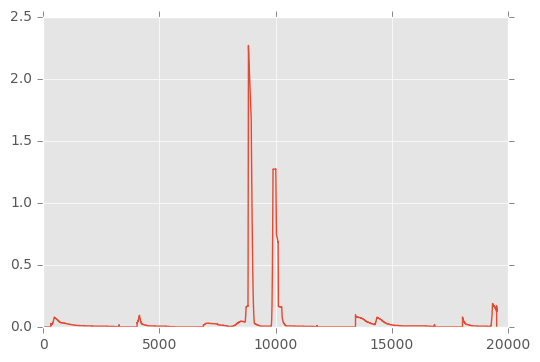

In [339]:
plt.plot(beta)

In [8]:
plt.plot(nice_alpha['streams'])

NameError: name 'nice_alpha' is not defined

In [2]:
reload(bp)
#plt.plot(beta)
b_s = 10

plt.plot(bp.col_binned(beta.reshape(1, -1), 30));


NameError: name 'bp' is not defined

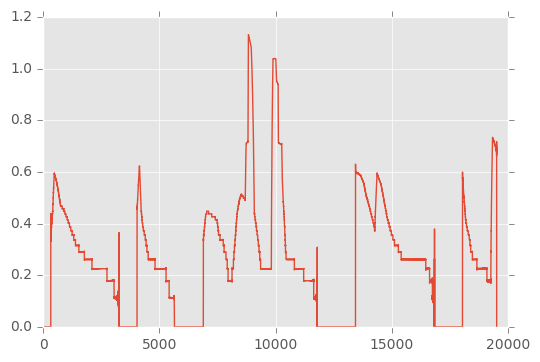

In [55]:
plt.plot(syn.np_mulog(beta))

In [ ]:
nice_beta = {'thresh_f': thresh_factor, 'bs': b_s, 'hb': h_b, 'streams': aux.transform_alpha(par_pred)}

In [250]:
reload(aux)
fit_result = aux.test_fit(chans, thresh, kwd_file, starts, recs, trials_train, trials_test, par_stream,
            bin_size=b_s,
            history_bins=h_b)

2016-12-13 12:24:46,285 spike_detect_aux INFO     Computer: passaro
2016-12-13 12:24:46,287 spike_detect_aux INFO     Fitting a kernel
2016-12-13 12:24:46,289 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-13 12:24:46,290 spike_detect_aux INFO     Collecting 65 frames...
2016-12-13 12:24:46,291 spike_detect_aux INFO     Frame 0 ...
2016-12-13 12:24:46,371 spike_detect_aux INFO     Frame 10 ...
2016-12-13 12:24:46,438 spike_detect_aux INFO     Frame 20 ...
2016-12-13 12:24:46,494 spike_detect_aux INFO     Frame 30 ...
2016-12-13 12:24:46,542 spike_detect_aux INFO     Frame 40 ...
2016-12-13 12:24:46,585 spike_detect_aux INFO     Frame 50 ...
2016-12-13 12:24:46,629 spike_detect_aux INFO     Frame 60 ...
2016-12-13 12:24:51,503 spike_detect_aux INFO     sv shape (32, 81, 65), target shape (65, 66)
2016-12-13 12:24:51,583 spike_detect_aux INFO     k shape (513,)
2016-12-13 12:24:51,584 spike_detect_aux INFO     Convolving a kernel
2016-12-13 12:24:51,585 spi

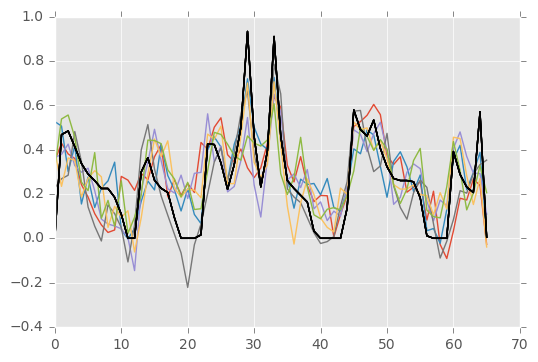

In [254]:
plt.plot(fit_result[1].T);
plt.plot(fit_result[3].T, 'k')

2016-12-14 13:40:08,397 spike_detect_aux INFO     Computer: passaro
2016-12-14 13:40:08,401 spike_detect_aux INFO     Testing for all pars with bin_size=11, history_size=29:
2016-12-14 13:40:08,403 spike_detect_aux INFO     Testing fit for a parameter
2016-12-14 13:40:08,404 spike_detect_aux INFO     Fitting a kernel
2016-12-14 13:40:08,406 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-14 13:40:08,407 spike_detect_aux INFO     Collecting 65 frames...
2016-12-14 13:40:08,408 spike_detect_aux INFO     Frame 0 ...
2016-12-14 13:40:08,501 spike_detect_aux INFO     Frame 10 ...
2016-12-14 13:40:08,572 spike_detect_aux INFO     Frame 20 ...
2016-12-14 13:40:08,633 spike_detect_aux INFO     Frame 30 ...
2016-12-14 13:40:08,699 spike_detect_aux INFO     Frame 40 ...
2016-12-14 13:40:08,764 spike_detect_aux INFO     Frame 50 ...
2016-12-14 13:40:08,831 spike_detect_aux INFO     Frame 60 ...
2016-12-14 13:40:14,368 spike_detect_aux INFO     sv shape (30, 89, 65), 

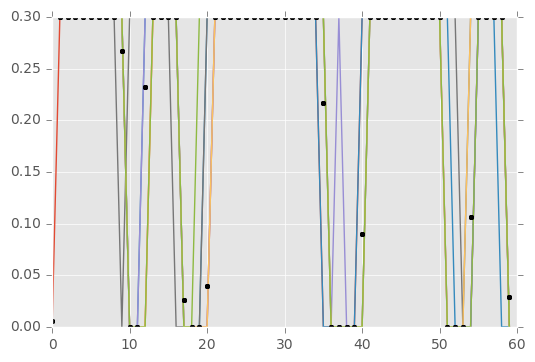

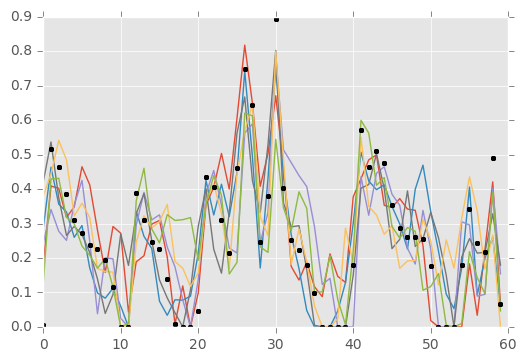

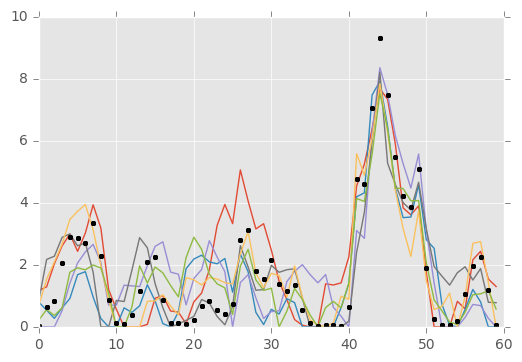

In [60]:
reload(aux)
b_s = 11
h_b = 29
thresh_factor = 5.5
thresh = rms*thresh_factor
all_result = aux.altogether_test(alpha, syn.np_mulog(beta), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k.')

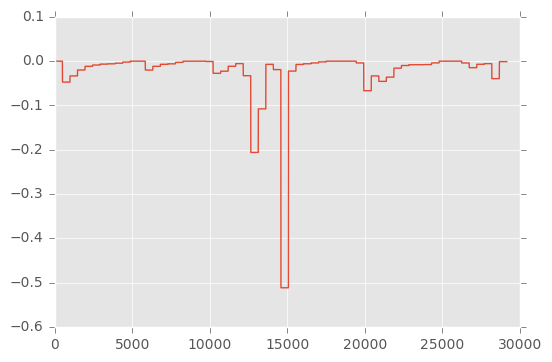

In [129]:
def resample_no_interp(x, s_f, new_s_f, axis=0):
    assert(new_s_f>=s_f)
    n_repeats = np.int(np.ceil(new_s_f/s_f))
    return np.repeat(x, n_repeats, axis=axis)

#now try to synthesise for this test
def latent_to_stream(onof, beta, alpha):
    onof[onof>.3] = .3
    onof[onof<0] = 0
    alpha[alpha<0]=0
    return np.vstack([0.15 - onof, -beta, alpha]).T

n_test = 5
fitted_streams = all_result[3][:,n_test,:]


abe_streams = latent_to_stream(fitted_streams[0, :], 
                               syn.np_mulog_inv(fitted_streams[1, :]), 
                               fitted_streams[2, :])

abe_streams_rs = resample_no_interp(abe_streams, 1000./b_s, 44100)
plt.plot(abe_streams_rs[:,1])

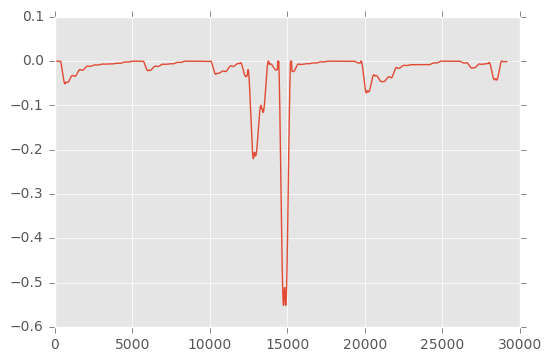

In [130]:
from scipy.signal import savgol_filter
abe_streams_rs[:,1] = savgol_filter(abe_streams_rs[:,1], 441, 3)
abe_streams_rs[abe_streams_rs[:,1] > 0, 1] = 0
# smooth_some
plt.plot(abe_streams_rs[:,1])

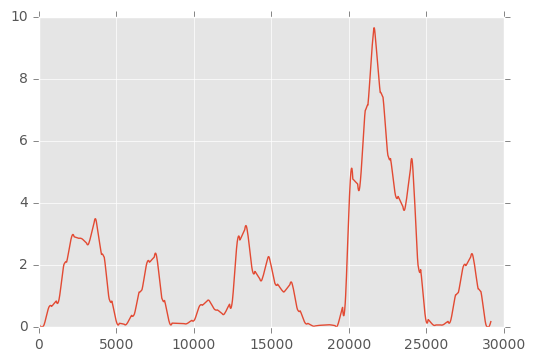

In [131]:
abe_streams_rs[:,2] = savgol_filter(abe_streams_rs[:,2], 661, 3)
abe_streams_rs[abe_streams_rs[:,2] < 0, 2] = 0
# smooth_some
plt.plot(abe_streams_rs[:,2])

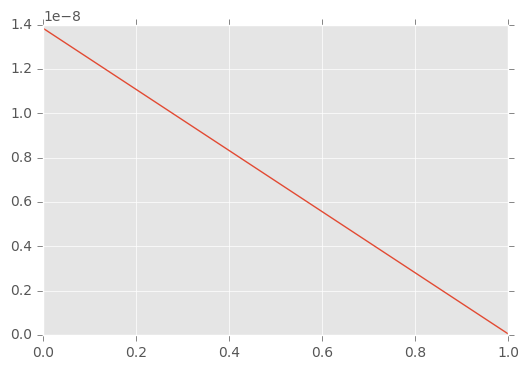

In [132]:
from dynamo import finch as zf
s_s = zf.make_song(abe_streams_rs)
plt.plot(s_s[:,0])

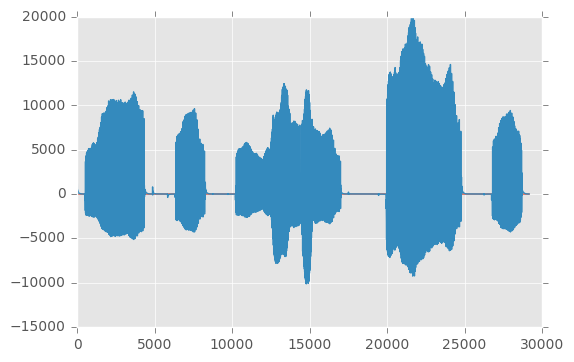

In [133]:
plt.plot(s_s[:, 0])
def wavify(x):
    return (x/np.ptp(x)*30000).astype(np.int16)

plt.plot(wavify(s_s[:, 0]))

wav_fn = os.path.join(et.file_names(bird, '002')['folders']['stim'], 'synth_thresh2.wav')
wavfile.write(wav_fn, 44100, wavify(s_s[:, 0]))


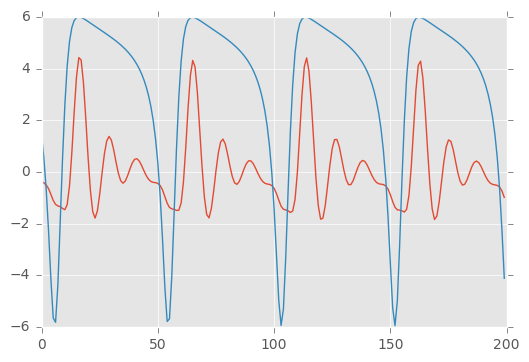

In [67]:
plt.plot(s_s[1500:1700, :])

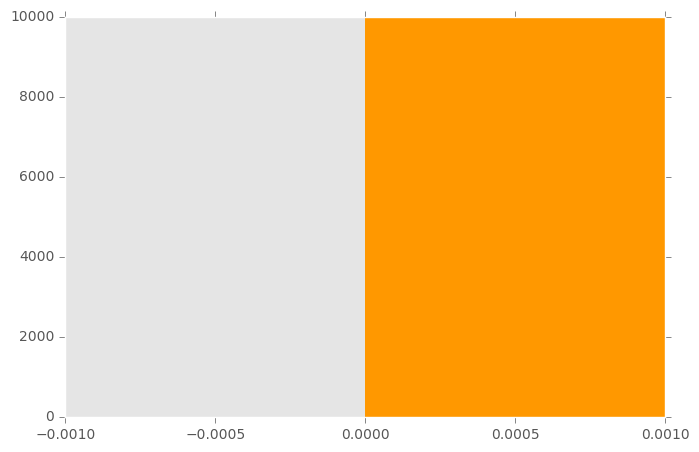

In [66]:
def plot_spectrogram(x, before_ms, after_ms, s_f, n_window = 192, n_overlap = None, sigma=None, ax=None, **kwargs):
    
    if n_overlap is None:
        n_overlap = n_window/2
    if sigma is None:
        sigma = 1./1000.*s_f
    
    # Make the spectrogram
    f, t, Sxx = spectrogram(x, s_f, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), 
                            scaling='spectrum')
    
    Sxx[[Sxx<np.max((Sxx)*0.000065)]]=1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms/1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms/1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    #Sxx = np.hstack((span_before, (Sxx), span_after))
    
    if ax is None:
        spec_fig = plt.figure()
        ax = spec_fig.add_axes([0, 0, 1, 1])
        
    ax.pcolormesh(((t-0.5*n_window/s_f)*1000.), f, np.log(Sxx), rasterized=True)
    ax.set_xlim(-before_ms, after_ms + int(x.size/s_f * 1000.))
    ax.set_ylim(0,10000)
    #ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    
    return Sxx, ax

spectr_bos, ax = plot_spectrogram(s_s[:, 0], 
                                   0, 0, 44100,
                                   n_window = 512, n_overlap=512-1, scaling='spectrum')

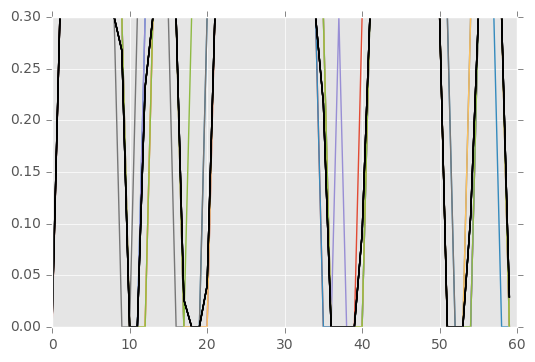

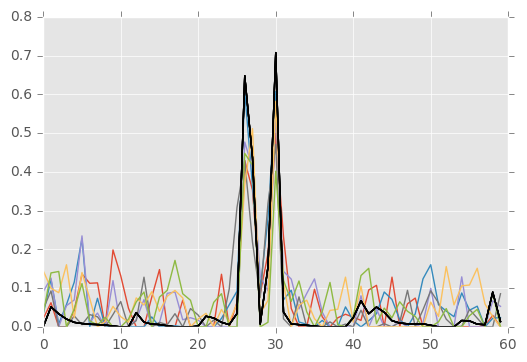

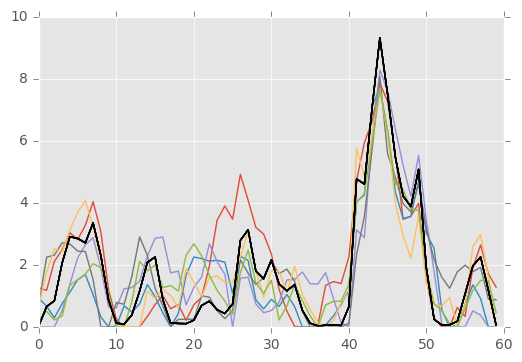

In [34]:
for i_par, _ in enumerate(all_result[0]):
    plt.figure()
    plt.plot(all_result[1][i_par].T);
    plt.plot(all_result[3][i_par].T, 'k')

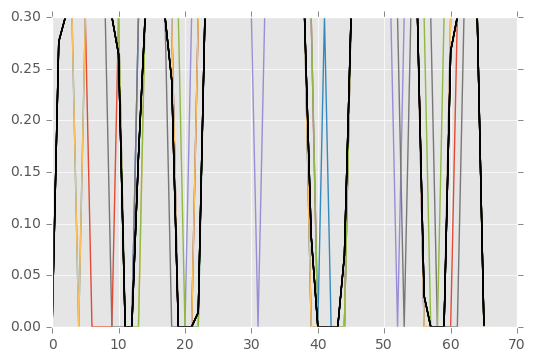

In [274]:
#plt.plot(all_result[1][0].T);
plt.plot(all_result[1][0].T);
plt.plot(all_result[3][0].T, 'k')

In [230]:
reload(aux)
env_pred = aux.linear_predict(chans[fitted_chans], thresh[fitted_chans], kwd_file, starts[trials_test], recs[trials_test], env.size, 
                              fitted_kernel, 
                   bin_size=b_s, 
                   history_bins=h_b, 
                   s_f=30000,
                   no_silent=False)

2016-12-13 10:39:17,631 spike_detect_aux INFO     Computer: passaro
2016-12-13 10:39:17,633 spike_detect_aux INFO     k shape (465,)
2016-12-13 10:39:17,635 spike_detect_aux INFO     Convolving a kernel
2016-12-13 10:39:17,636 spike_detect_aux INFO     Channels are 29
2016-12-13 10:39:17,638 spike_detect_aux INFO     Creating support vector 29 chans, 6 trials
2016-12-13 10:39:17,639 spike_detect_aux INFO     Collecting 6 frames...
2016-12-13 10:39:17,641 spike_detect_aux INFO     Frame 0 ...
2016-12-13 10:39:18,073 spike_detect_aux INFO     kernel shape (465,), sv_shape (29, 81, 6), len_samples 19503


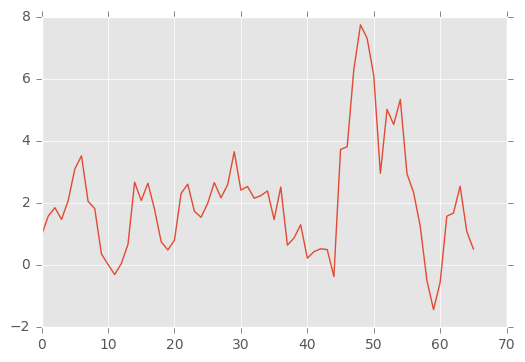

In [251]:
plt.plot(env_pred[1])

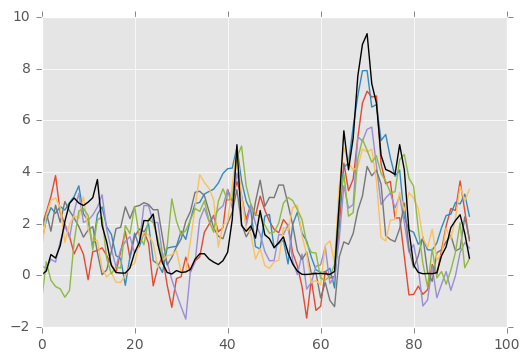

In [185]:
plt.plot(env_pred.T);
plt.plot(bp.col_binned(env.reshape(1, -1), b_s*30).T/(b_s*30), 'k');

In [178]:
all_result = aux.altogether_test(alpha, beta, env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                                 bin_size=b_s,
                                 history_bins=h_b)

array([[ 0.11122297,  0.10719738,  0.10260112, ...,  2.7971164 ,
         2.64351626,  1.48117981]])

In [289]:
s_f

30000

In [293]:
bins = [5, 6, 7, 8, 9, 10, 12, 15]
histories = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 27]
tests_sweep = []
for bs in bins:
    bs_sweep = []
    for hs in histories:
        logger.info('Testing with bs={0}, hs={1}:'.format(bs, hs))
        ev_tst = aux.altogether_test(alpha, syn.np_mulog(beta, 256), env, 
                                 chans, thresh, kwd_file, starts, recs, trials_train, trials_test,
                             bin_size=bs, 
                             history_bins=hs, 
                             s_f=s_f, 
                             nl_alpha = aux.transform_alpha, 
                             nl_beta = aux.transform_beta, 
                             nl_env = aux.transform_env
                            )
        bs_sweep.append(ev_tst)
    tests_sweep.append(bs_sweep)

2016-12-13 13:03:18,698 root         INFO     Testing with bs=5, hs=5:
2016-12-13 13:03:18,702 spike_detect_aux INFO     Testing for all pars with bin_size=5, history_size=5:
2016-12-13 13:03:18,703 spike_detect_aux INFO     Testing fit for a parameter
2016-12-13 13:03:18,705 spike_detect_aux INFO     Fitting a kernel
2016-12-13 13:03:18,707 spike_detect_aux INFO     Creating support vector 32 chans, 65 trials
2016-12-13 13:03:18,708 spike_detect_aux INFO     Collecting 65 frames...
2016-12-13 13:03:18,709 spike_detect_aux INFO     Frame 0 ...
2016-12-13 13:03:18,777 spike_detect_aux INFO     Frame 10 ...
2016-12-13 13:03:18,832 spike_detect_aux INFO     Frame 20 ...
2016-12-13 13:03:18,884 spike_detect_aux INFO     Frame 30 ...
2016-12-13 13:03:18,925 spike_detect_aux INFO     Frame 40 ...
2016-12-13 13:03:18,963 spike_detect_aux INFO     Frame 50 ...
2016-12-13 13:03:19,000 spike_detect_aux INFO     Frame 60 ...
2016-12-13 13:03:22,301 spike_detect_aux INFO     sv shape (32, 136, 65)

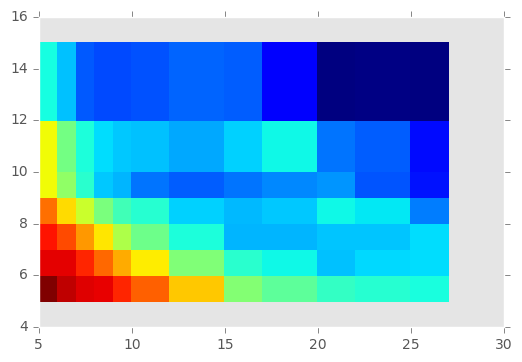

In [320]:
import itertools
n_bs = len(bins)
n_hs = len(histories)
k_par = 1

res_array = np.zeros([n_bs, n_hs, 3])
for b, h in itertools.product(range(n_bs), range(n_hs)):
    res_array[b, h, :] = tests_sweep[b][h][2]
plt.pcolormesh(histories, bins, res_array[:,:,k_par])

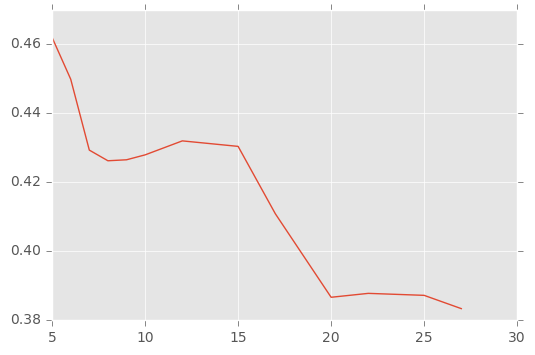

In [324]:
plt.plot(histories, res_array[6,:,k_par])